In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input
from tensorflow import keras

In [2]:
import pandas as pd

data=pd.read_csv(r"C:\Users\ulami\Desktop\datasety\UNSW-NB15\all_data_without_nan_after_proc.csv")

In [3]:
data.head()

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,is_ftp_login,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,120,2,0.036133,528,304,31,29,0,0,0,...,0.0,2,4,2,3,1,1,2,13,0
1,120,2,0.001119,146,178,31,29,0,0,2,...,0.0,12,8,1,2,2,1,1,13,0
2,120,2,0.001209,132,164,31,29,0,0,2,...,0.0,6,9,1,1,1,1,1,13,0
3,120,2,0.001169,146,178,31,29,0,0,2,...,0.0,7,9,1,1,1,1,1,13,0
4,120,2,0.078339,568,312,31,29,0,0,0,...,0.0,2,4,2,3,1,1,2,13,0


In [4]:
print(data['Label'].value_counts())

Label
0    1064986
1      22215
Name: count, dtype: int64


In [5]:
print(data['sttl'].value_counts())

sttl
31     1039445
254      22951
0         6600
60        6020
62        4446
1         3052
29        2682
32        1599
30         225
64         121
255         31
252         27
63           2
Name: count, dtype: int64


In [6]:
X = data.drop(['attack_cat', 'Label'], axis=1)
Y = data['Label']

In [6]:
import optuna
from optuna.integration import TFKerasPruningCallback
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

X = data.drop(columns=['attack_cat', 'Label']).values
y = data['Label'].values

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1
)

# ---------------------------
# Model factory
# ---------------------------
def create_model(trial, input_dim):
    model = Sequential()
    n_layers = trial.suggest_int("n_layers", 2, 5)
    for i in range(n_layers):
        units = trial.suggest_categorical(f"n_units_l{i}", [4, 8, 16, 32, 64])
        dropout_rate = trial.suggest_categorical(f"dropout_l{i}", [0.0, 0.1, 0.2])

        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=(input_dim,)))
        else:
            model.add(Dense(units, activation='relu'))

        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ---------------------------
# 2) Optuna objective with Stratified K-Fold on trainval
#    + collect out-of-fold predictions to build one CV report per trial
# ---------------------------
trial_reports = []

def objective(trial):
    n_epochs   = trial.suggest_int("epochs", 3, 10)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    # Out-of-fold (OOF) predictions aligned to y_trainval
    oof_pred = np.full(shape=y_trainval.shape[0], fill_value=np.nan, dtype=float)

    fold_f1s = []
    folds_meta = []
    for fold_idx, (tr_idx, va_idx) in enumerate(skf.split(X_trainval, y_trainval), start=1):
        X_tr, X_va = X_trainval[tr_idx], X_trainval[va_idx]
        y_tr, y_va = y_trainval[tr_idx], y_trainval[va_idx]

        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_va = scaler.transform(X_va)

        model = create_model(trial, input_dim=X_tr.shape[1])

        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
        pruning_cb = TFKerasPruningCallback(trial, "val_accuracy")

        model.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=n_epochs,
            batch_size=32,
            verbose=0,
            callbacks=[early_stop, pruning_cb]
        )

        va_prob = model.predict(X_va, verbose=1).ravel()
        oof_pred[va_idx] = va_prob
        va_pred = (va_prob > 0.5).astype(int)

        rep = classification_report(y_va, va_pred, output_dict=True, zero_division=0)
        f1_macro = rep['macro avg']['f1-score']
        fold_f1s.append(f1_macro)
        folds_meta.append({'fold': fold_idx, 'f1_macro': float(f1_macro)})

        trial.report(np.mean(fold_f1s), step=fold_idx)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Build ONE report per trial from OOF predictions (same structure you used before)
    assert not np.isnan(oof_pred).any(), "OOF predictions not fully filled"
    oof_label = (oof_pred > 0.5).astype(int)
    cv_report = classification_report(y_trainval, oof_label, output_dict=True, zero_division=0)

    # Save exactly the fields your flattening code expects
    trial_reports.append({
        'trial_number': trial.number,
        'params': trial.params,
        'report': cv_report,   # has keys: 'accuracy', 'macro avg', '0', '1', ...
        'folds': folds_meta,
        'mean_f1_macro': float(np.mean(fold_f1s))
    })

    return float(np.mean(fold_f1s))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_trial.params)
print(f"Best CV macro F1: {study.best_value:.4f}")


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-17 10:34:31,464] A new study created in memory with name: no-name-26da17bd-a5a9-49b8-89d6-091edf97d4c6
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 6s 616us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

  82/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 640us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 6s 605us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

  83/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 664us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 6s 614us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 10:42:59,722] Trial 0 finished with value: 0.959473924294968 and parameters: {'epochs': 6, 'n_layers': 5, 'n_units_l0': 8, 'dropout_l0': 0.2, 'n_units_l1': 64, 'dropout_l1': 0.2, 'n_units_l2': 16, 'dropout_l2': 0.1, 'n_units_l3': 64, 'dropout_l3': 0.1, 'n_units_l4': 4, 'dropout_l4': 0.1}. Best is trial 0 with value: 0.959473924294968.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 6s 619us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 580us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 120/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 540us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 548us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 10:50:42,855] Trial 1 finished with value: 0.9618881474778224 and parameters: {'epochs': 6, 'n_layers': 3, 'n_units_l0': 16, 'dropout_l0': 0.1, 'n_units_l1': 4, 'dropout_l1': 0.0, 'n_units_l2': 16, 'dropout_l2': 0.0}. Best is trial 1 with value: 0.9618881474778224.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 599us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


  99/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 652us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 597us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


  72/9060 ━━━━━━━━━━━━━━━━━━━━ 6s 721us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 570us/step


[I 2025-08-17 10:55:04,938] Trial 2 finished with value: 0.9623812406016051 and parameters: {'epochs': 3, 'n_layers': 4, 'n_units_l0': 32, 'dropout_l0': 0.2, 'n_units_l1': 64, 'dropout_l1': 0.0, 'n_units_l2': 32, 'dropout_l2': 0.1, 'n_units_l3': 64, 'dropout_l3': 0.0}. Best is trial 2 with value: 0.9623812406016051.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 564us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 184/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 609us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 498us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

  97/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 541us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 574us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 11:06:40,644] Trial 3 finished with value: 0.9623824247443732 and parameters: {'epochs': 9, 'n_layers': 4, 'n_units_l0': 16, 'dropout_l0': 0.1, 'n_units_l1': 8, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.1, 'n_units_l3': 4, 'dropout_l3': 0.2}. Best is trial 3 with value: 0.9623824247443732.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 559us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 517us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 185/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 576us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 11:13:58,596] Trial 4 finished with value: 0.9620406127099826 and parameters: {'epochs': 6, 'n_layers': 4, 'n_units_l0': 16, 'dropout_l0': 0.0, 'n_units_l1': 8, 'dropout_l1': 0.0, 'n_units_l2': 32, 'dropout_l2': 0.2, 'n_units_l3': 32, 'dropout_l3': 0.1}. Best is trial 3 with value: 0.9623824247443732.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-17 11:14:24,996] Trial 5 pruned. Trial was pruned at epoch 0.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\d

9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 554us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 159/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 635us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 531us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 184/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 579us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 567us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 11:22:27,905] Trial 12 finished with value: 0.9642865553379357 and parameters: {'epochs': 4, 'n_layers': 4, 'n_units_l0': 32, 'dropout_l0': 0.1, 'n_units_l1': 16, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.1, 'n_units_l3': 64, 'dropout_l3': 0.0}. Best is trial 12 with value: 0.9642865553379357.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-17 11:22:54,713] Trial 13 pruned. Trial was pruned at epoch 0.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\cor

9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 560us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 509us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 184/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 556us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 537us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 11:34:41,377] Trial 15 finished with value: 0.9652311545107795 and parameters: {'epochs': 10, 'n_layers': 3, 'n_units_l0': 32, 'dropout_l0': 0.1, 'n_units_l1': 4, 'dropout_l1': 0.0, 'n_units_l2': 8, 'dropout_l2': 0.1}. Best is trial 15 with value: 0.9652311545107795.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-17 11:35:30,667] Trial 16 pruned. Trial was pruned at epoch 1.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pa

9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 520us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 181/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 584us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 535us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 192/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 533us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 495us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 11:45:30,412] Trial 20 finished with value: 0.9634126513984466 and parameters: {'epochs': 5, 'n_layers': 2, 'n_units_l0': 32, 'dropout_l0': 0.0, 'n_units_l1': 4, 'dropout_l1': 0.0}. Best is trial 15 with value: 0.9652311545107795.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 539us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 207/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 501us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 103/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 520us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 496us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 11:51:27,169] Trial 21 finished with value: 0.9657460228108782 and parameters: {'epochs': 5, 'n_layers': 2, 'n_units_l0': 32, 'dropout_l0': 0.0, 'n_units_l1': 4, 'dropout_l1': 0.0}. Best is trial 21 with value: 0.9657460228108782.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-17 11:51:50,662] Trial 22 pruned. Trial was pruned at epoch 0.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argum

9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 560us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 194/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 523us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 219/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 523us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 538us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 11:56:43,834] Trial 23 finished with value: 0.9641486876380464 and parameters: {'epochs': 4, 'n_layers': 2, 'n_units_l0': 32, 'dropout_l0': 0.0, 'n_units_l1': 4, 'dropout_l1': 0.0}. Best is trial 21 with value: 0.9657460228108782.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-17 11:57:08,711] Trial 24 pruned. Trial was pruned at epoch 0.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argum

9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 523us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

  91/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 560us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 566us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 189/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 552us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 6s 615us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 12:09:25,103] Trial 37 finished with value: 0.9625683458509086 and parameters: {'epochs': 4, 'n_layers': 4, 'n_units_l0': 32, 'dropout_l0': 0.0, 'n_units_l1': 32, 'dropout_l1': 0.0, 'n_units_l2': 4, 'dropout_l2': 0.1, 'n_units_l3': 64, 'dropout_l3': 0.0}. Best is trial 21 with value: 0.9657460228108782.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 547us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 530us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 192/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 535us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 539us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 12:16:23,104] Trial 38 finished with value: 0.9641397927581439 and parameters: {'epochs': 6, 'n_layers': 2, 'n_units_l0': 64, 'dropout_l0': 0.1, 'n_units_l1': 8, 'dropout_l1': 0.0}. Best is trial 21 with value: 0.9657460228108782.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-17 12:16:49,765] Trial 39 pruned. Trial was pruned at epoch 0.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argum

9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 520us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 190/9060 ━━━━━━━━━━━━━━━━━━━━ 4s 540us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 521us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: 

 183/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 592us/step 

C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


9060/9060 ━━━━━━━━━━━━━━━━━━━━ 5s 587us/step


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
[I 2025-08-17 12:27:10,573] Trial 47 finished with value: 0.9643271488533688 and parameters: {'epochs': 5, 'n_layers': 4, 'n_units_l0': 64, 'dropout_l0': 0.1, 'n_units_l1': 16, 'dropout_l1': 0.0, 'n_units_l2': 32, 'dropout_l2': 0.1, 'n_units_l3': 32, 'dropout_l3': 0.0}. Best is trial 21 with value: 0.9657460228108782.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-08-17 12:28:25,709] Trial 48 pruned. Trial was pruned at epoch 2.
C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\co

Best params: {'epochs': 5, 'n_layers': 2, 'n_units_l0': 32, 'dropout_l0': 0.0, 'n_units_l1': 4, 'dropout_l1': 0.0}
Best CV macro F1: 0.9657


In [7]:
# Po zakończeniu study.optimize(...)

# Przekształcenie do DataFrame: jeden wiersz = jeden trial
flattened_reports = []
for entry in trial_reports:
    flat = {
        'trial_number': entry['trial_number'],
        **entry['params'],
        'accuracy': entry['report']['accuracy'],
        'macro_f1': entry['report']['macro avg']['f1-score'],
        'macro_precision': entry['report']['macro avg']['precision'],
        'macro_recall': entry['report']['macro avg']['recall'],
        'class_0_f1': entry['report']['0']['f1-score'],
        'class_1_f1': entry['report']['1']['f1-score']
    }
    flattened_reports.append(flat)

df_reports = pd.DataFrame(flattened_reports)
df_reports.to_csv('optuna_UNSW_NB15_classification_reports.csv', index=False)

print("Zapisano raporty do: optuna_UNSW_NB15_classification_reports.csv")


Zapisano raporty do: optuna_UNSW_NB15_classification_reports.csv


In [8]:
scaler_full = StandardScaler().fit(X_trainval)
X_trainval_scaled = scaler_full.transform(X_trainval)
X_test_scaled = scaler_full.transform(X_test)

best_model = create_model(study.best_trial, input_dim=X_trainval_scaled.shape[1])
best_model.fit(
    X_trainval_scaled, y_trainval,
    epochs=study.best_trial.params['epochs'],
    batch_size=32,
    verbose=1
)

y_test_pred = (best_model.predict(X_test_scaled, verbose=1).ravel() > 0.5).astype(int)
final_report = classification_report(y_test, y_test_pred, zero_division=0)
print("Final Test Set Report:")
print(final_report)

Epoch 1/5


C:\Users\ulami\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27180/27180 ━━━━━━━━━━━━━━━━━━━━ 23s 831us/step - accuracy: 0.9888 - loss: 0.1440
Epoch 2/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 23s 840us/step - accuracy: 0.9966 - loss: 0.0072
Epoch 3/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 24s 864us/step - accuracy: 0.9970 - loss: 0.0061
Epoch 4/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 24s 873us/step - accuracy: 0.9971 - loss: 0.0059
Epoch 5/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 24s 885us/step - accuracy: 0.9971 - loss: 0.0058
6796/6796 ━━━━━━━━━━━━━━━━━━━━ 4s 567us/step
Final Test Set Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    212998
           1       0.96      0.89      0.92      4443

    accuracy                           1.00    217441
   macro avg       0.98      0.94      0.96    217441
weighted avg       1.00      1.00      1.00    217441



In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


Test Accuracy: 99.70%
Test Precision: 99.69%
Test Recall: 99.70%


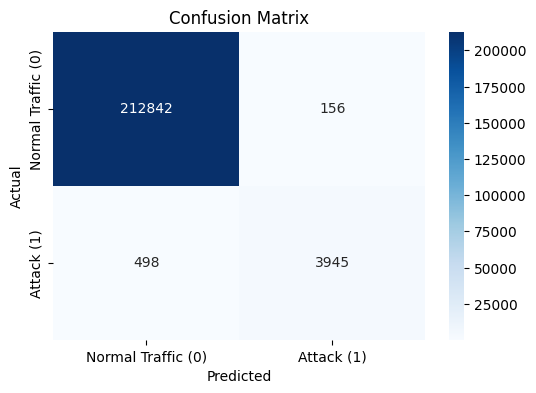

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    212998
        Attack       0.96      0.89      0.92      4443

      accuracy                           1.00    217441
     macro avg       0.98      0.94      0.96    217441
  weighted avg       1.00      1.00      1.00    217441



In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_test_pred, target_names=['Normal Traffic', 'Attack']))


In [11]:
import optuna.visualization as vis

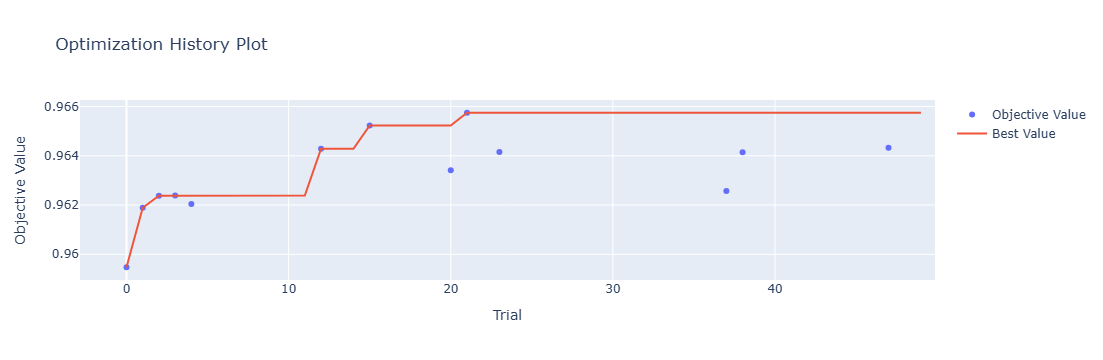

In [12]:
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.show()

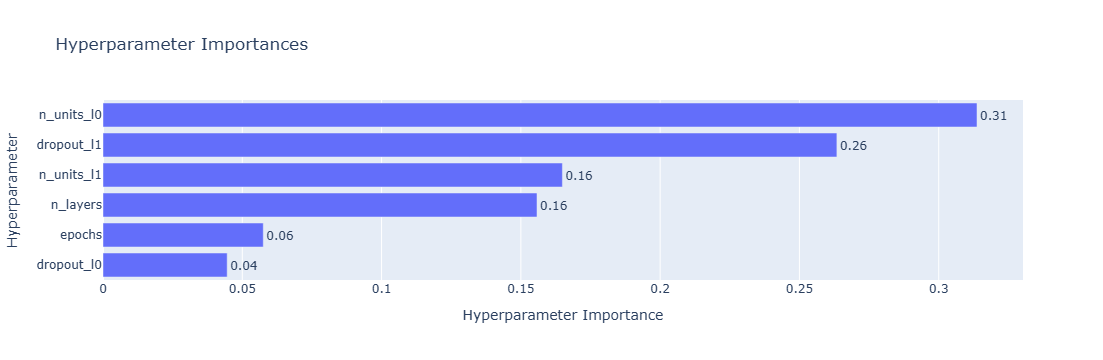

In [13]:
optuna.visualization.plot_param_importances(study).show()


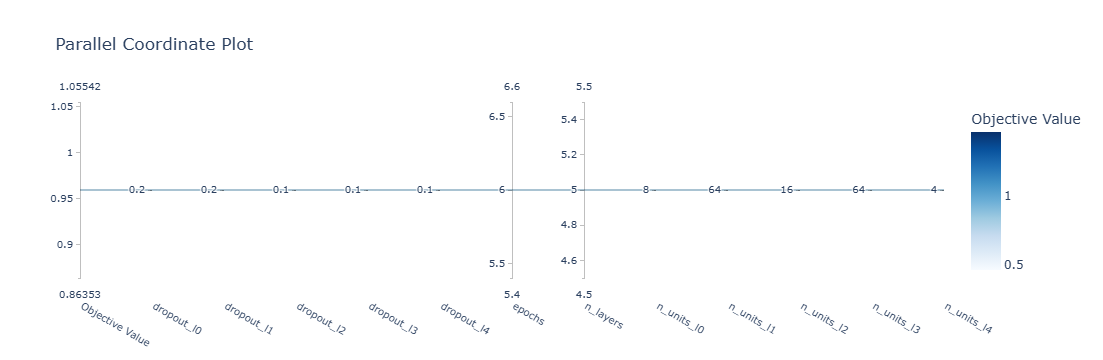

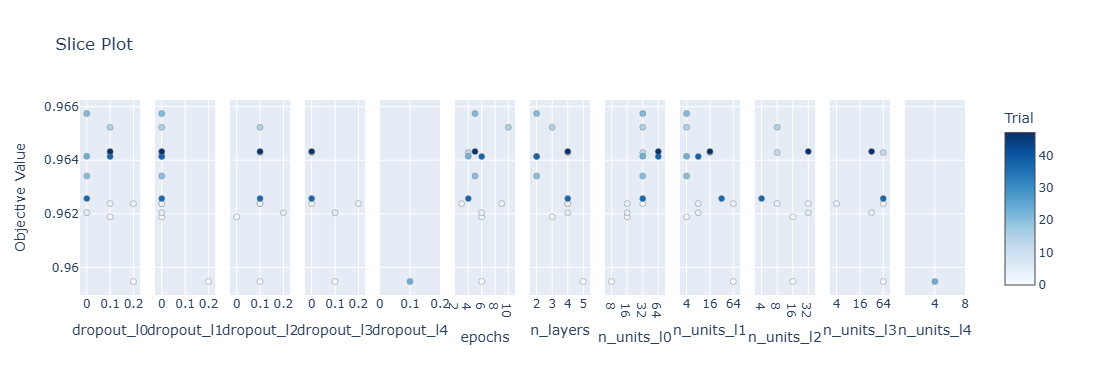

In [14]:
fig3 = optuna.visualization.plot_parallel_coordinate(study)
fig3.show()

fig4 = optuna.visualization.plot_slice(study)
fig4.show()

# Feature Selection with Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

X_df = data.drop(columns=['attack_cat', 'Label']) # Keep as DataFrame
y = data['Label']

# Train a Random Forest model for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_df, y)
feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_df.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
5,sttl,0.197603
32,ct_state_ttl,0.163063
19,dmeansz,0.059642
10,Sload,0.054844
30,ackdat,0.046424
6,dttl,0.043748
3,sbytes,0.039784
29,synack,0.037702
28,tcprtt,0.037401
18,smeansz,0.035313


In [19]:
print(len(feature_importance_df))
print(len(X_df.columns))

42
42


In [20]:
# ----- Your fixed best hyperparameters -----
best_params = {
    'epochs': 5,
    'n_layers': 2,
    'n_units_l0': 32, 'dropout_l0': 0.0,
    'n_units_l1': 4, 'dropout_l1': 0.0,
    'learning_rate': 1e-3,
    'batch_size': 32
}

13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 497us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 542us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 480us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 477us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 507us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 485us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 8s 573us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 501us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 534us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 512us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 494us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 535us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 8s 560us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 506us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 8s 558us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 523us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 521us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 513us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 8s 556us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 523us/step
13590/13590 ━━━━━━━━━━━━━━━━━━━━ 7s 525us/step
13590/13590 ━

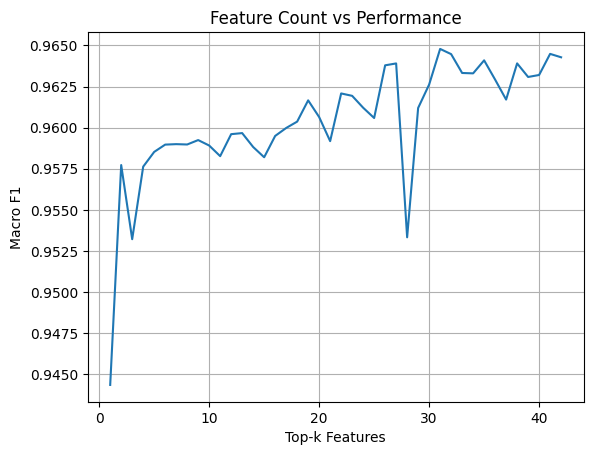

Selected features: ['sttl', 'ct_state_ttl', 'dmeansz', 'Sload', 'ackdat', 'dttl', 'sbytes', 'synack', 'tcprtt', 'smeansz', 'Dload', 'state', 'dbytes', 'Dintpkt', 'dur', 'Ltime', 'Stime', 'ct_srv_dst', 'ct_srv_src', 'Sintpkt', 'Dpkts', 'ct_dst_sport_ltm', 'proto', 'service', 'Spkts', 'ct_src_ ltm', 'Djit', 'sloss', 'Sjit', 'ct_src_dport_ltm', 'ct_dst_src_ltm']
Epoch 1/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 24s 846us/step - accuracy: 0.9948 - loss: 0.0170
Epoch 2/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 22s 824us/step - accuracy: 0.9970 - loss: 0.0061
Epoch 3/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 22s 819us/step - accuracy: 0.9971 - loss: 0.0058
Epoch 4/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 23s 851us/step - accuracy: 0.9972 - loss: 0.0057
Epoch 5/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 23s 832us/step - accuracy: 0.9972 - loss: 0.0056
6796/6796 ━━━━━━━━━━━━━━━━━━━━ 3s 496us/step
Final Test Set Report (using best_k features):
              precision    recall  f1-score   support

           0       1.00      1.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# ----- Split once: trainval / test -----

X_df = data.drop(columns=['attack_cat', 'Label']) # Keep as DataFrame
y = data['Label'].values

X_trainval_df, X_test_df, y_trainval, y_test = train_test_split(
    X_df, y, test_size=0.2, stratify=y, random_state=1
)

# ----- Model builder using your fixed params -----
def build_model(input_dim: int):
    m = Sequential()
    m.add(Input(shape=(input_dim,)))
    for i in range(best_params['n_layers']):
        units = best_params.get(f"n_units_l{i}")
        dr = best_params.get(f"dropout_l{i}", 0.0)
        m.add(Dense(units, activation='relu'))
        if dr and dr > 0:
            m.add(Dropout(dr))
    m.add(Dense(1, activation='sigmoid'))
    m.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='binary_crossentropy', metrics=['accuracy'])
    return m

# ----- Prepare top-k feature order (from your RandomForest importances) -----
top_features = (
    feature_importance_df.sort_values('Importance', ascending=False)['Feature']
    .tolist()
)
top_features = [f for f in top_features if f in X_trainval_df.columns]
max_k = len(top_features)

# ----- CV eval for a given k (on trainval only; scaling inside each fold) -----
def cv_macro_f1_for_k(k: int, n_splits: int = 2, seed: int = 1):
    feats = top_features[:k]
    Xk = X_trainval_df[feats].values
    yk = y_trainval

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold_scores = []

    for tr_idx, va_idx in skf.split(Xk, yk):
        X_tr, X_va = Xk[tr_idx], Xk[va_idx]
        y_tr, y_va = yk[tr_idx], yk[va_idx]

        scaler = StandardScaler().fit(X_tr)
        X_tr = scaler.transform(X_tr)
        X_va = scaler.transform(X_va)

        model = build_model(input_dim=X_tr.shape[1])
        early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

        model.fit(X_tr, y_tr,
                  validation_data=(X_va, y_va),
                  epochs=best_params['epochs'],
                  batch_size=best_params['batch_size'],
                  verbose=0,
                  callbacks=[early])

        preds = (model.predict(X_va, verbose=1).ravel() > 0.5).astype(int)
        rep = classification_report(y_va, preds, output_dict=True, zero_division=0)
        fold_scores.append(rep['macro avg']['f1-score'])

    return float(np.mean(fold_scores)), float(np.std(fold_scores))

# ----- Search k = 1..max_k -----
results = []
for k in range(1, max_k + 1):
    mean_f1, std_f1 = cv_macro_f1_for_k(k)
    results.append({'k': k, 'mean_macro_f1': mean_f1, 'std_macro_f1': std_f1})

df_k = pd.DataFrame(results)
best_row = df_k.iloc[df_k['mean_macro_f1'].idxmax()]
best_k = int(best_row['k'])
print(f"Best k = {best_k} with mean CV macro F1 = {best_row['mean_macro_f1']:.4f}")

# ----- Plot performance vs k -----
plt.figure()
plt.plot(df_k['k'], df_k['mean_macro_f1'])
plt.xlabel('Top-k Features')
plt.ylabel('Macro F1')
plt.title('Feature Count vs Performance')
plt.grid(True)
plt.show()

# ----- Final train on all trainval with best_k features; evaluate once on test -----
selected_features = top_features[:best_k]
print("Selected features:", selected_features)

Xtr_sel = X_trainval_df[selected_features].values
Xte_sel = X_test_df[selected_features].values

scaler_full = StandardScaler().fit(Xtr_sel)
Xtr_sel = scaler_full.transform(Xtr_sel)
Xte_sel = scaler_full.transform(Xte_sel)

final_model = build_model(input_dim=Xtr_sel.shape[1])
final_model.fit(
    Xtr_sel, y_trainval,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

test_preds = (final_model.predict(Xte_sel, verbose=1).ravel() > 0.5).astype(int)
final_report = classification_report(y_test, test_preds, zero_division=0)
print("Final Test Set Report (using best_k features):")
print(final_report)


In [23]:
df_k

,k,mean_macro_f1,std_macro_f1
0,1,0.944357,0.001091
1,2,0.957725,0.002110
2,3,0.953217,0.006762
3,4,0.957627,0.001144
4,5,0.958524,0.001808
5,6,0.958968,0.002089
6,7,0.958996,0.001338
7,8,0.958975,0.001987
8,9,0.959243,0.001817
9,10,0.958912,0.002763


# WYBRANE 18 NAJWAŻNIEJSZYCH CECH

In [24]:
# ----- Final train on all trainval with best_k features; evaluate once on test -----
selected_features = top_features[:18]
print("Selected features:", selected_features)

Xtr_sel = X_trainval_df[selected_features].values
Xte_sel = X_test_df[selected_features].values

scaler_full = StandardScaler().fit(Xtr_sel)
Xtr_sel = scaler_full.transform(Xtr_sel)
Xte_sel = scaler_full.transform(Xte_sel)

final_model = build_model(input_dim=Xtr_sel.shape[1])
final_model.fit(
    Xtr_sel, y_trainval,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

test_preds = (final_model.predict(Xte_sel, verbose=1).ravel() > 0.5).astype(int)
final_report = classification_report(y_test, test_preds, zero_division=0)
print("Final Test Set Report (using best_k features):")
print(final_report)

Selected features: ['sttl', 'ct_state_ttl', 'dmeansz', 'Sload', 'ackdat', 'dttl', 'sbytes', 'synack', 'tcprtt', 'smeansz', 'Dload', 'state', 'dbytes', 'Dintpkt', 'dur', 'Ltime', 'Stime', 'ct_srv_dst']
Epoch 1/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 24s 880us/step - accuracy: 0.9926 - loss: 0.0266
Epoch 2/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 24s 866us/step - accuracy: 0.9965 - loss: 0.0077
Epoch 3/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 23s 843us/step - accuracy: 0.9967 - loss: 0.0074
Epoch 4/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 24s 873us/step - accuracy: 0.9969 - loss: 0.0069
Epoch 5/5
27180/27180 ━━━━━━━━━━━━━━━━━━━━ 24s 866us/step - accuracy: 0.9967 - loss: 0.0067
6796/6796 ━━━━━━━━━━━━━━━━━━━━ 3s 508us/step
Final Test Set Report (using best_k features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    212998
           1       0.91      0.94      0.93      4443

    accuracy                           1.00    217441
   macro avg       0.95      

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Calculate metrics
accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds, average='weighted')  # Use 'macro' or 'micro' for different averaging
recall = recall_score(y_test, test_preds, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


Test Accuracy: 99.69%
Test Precision: 99.70%
Test Recall: 99.69%


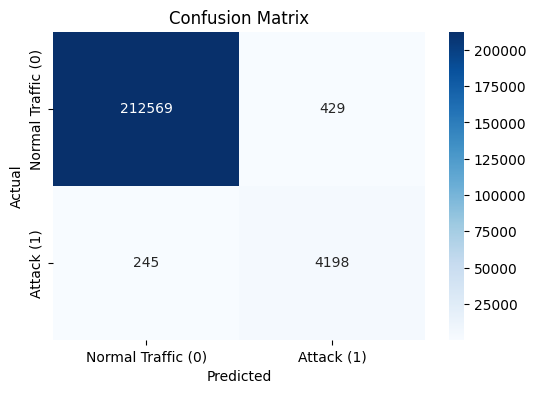

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    212998
        Attack       0.91      0.94      0.93      4443

      accuracy                           1.00    217441
     macro avg       0.95      0.97      0.96    217441
  weighted avg       1.00      1.00      1.00    217441



In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test, test_preds, target_names=['Normal Traffic', 'Attack']))


In [27]:
# # Save the trained model
final_model.save("UNSW_NB15_csv_final.keras")

In [4]:
from tensorflow.keras.models import load_model
final_model = load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\UNSW_NB15_csv_final.keras")   

# FGSM

In [28]:
import tensorflow as tf
import numpy as np

# Separate attack and normal samples
X_test_attack = Xte_sel[y_test == 1]
y_test_attack = y_test[y_test == 1]

X_test_normal = Xte_sel[y_test == 0]
y_test_normal = y_test[y_test == 0]

# Convert to tensors
X_attack_tensor = tf.convert_to_tensor(X_test_attack, dtype=tf.float32)
y_attack_tensor = tf.convert_to_tensor(y_test_attack.astype(np.float32))  # <- remove .values

# FGSM
def fgsm_attack(model, X, y, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(X)
        predictions = model(X)
        loss = tf.keras.losses.binary_crossentropy(tf.reshape(y, (-1, 1)), predictions)
    gradient = tape.gradient(loss, X)
     # Print gradient statistics
    print("Gradient stats:")
    print("  Min:", tf.reduce_min(gradient).numpy())
    print("  Max:", tf.reduce_max(gradient).numpy())
    print("  Mean:", tf.reduce_mean(gradient).numpy()) 
    avg_abs_grad = tf.reduce_mean(tf.abs(gradient), axis=0)
    print("Avg abs gradient per feature:", avg_abs_grad.numpy())
    signed_grad = tf.sign(gradient)
    X_adv = X + epsilon * signed_grad
    return X_adv.numpy()

# Generate adversarial attack examples
epsilon = 0.3
X_attack_adv = fgsm_attack(final_model, X_attack_tensor, y_attack_tensor, epsilon=epsilon)

# Combine normal and adversarial attack samples back together
X_test_combined = np.vstack((X_test_normal, X_attack_adv))
y_test_combined = np.hstack((y_test_normal, y_test_attack))

# shuffle the test set
from sklearn.utils import shuffle
X_test_adv_final, y_test_adv_final = shuffle(X_test_combined, y_test_combined, random_state=1)

Gradient stats:
  Min: -3.9291232
  Max: 4.3569474
  Mean: -0.008619775
Avg abs gradient per feature: [0.03051898 0.01534259 0.0609132  0.01201133 0.01668486 0.01105658
 0.02145385 0.02034364 0.01009674 0.04133483 0.01569602 0.03373316
 0.0441159  0.00819941 0.1075601  0.05633737 0.05742814 0.17042114]


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred = final_model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_adv_final, y_pred)
precision = precision_score(y_test_adv_final, y_pred, average='weighted')
recall = recall_score(y_test_adv_final, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


6796/6796 ━━━━━━━━━━━━━━━━━━━━ 6s 812us/step
Test Accuracy: 98.71%
Test Precision: 98.56%
Test Recall: 98.71%


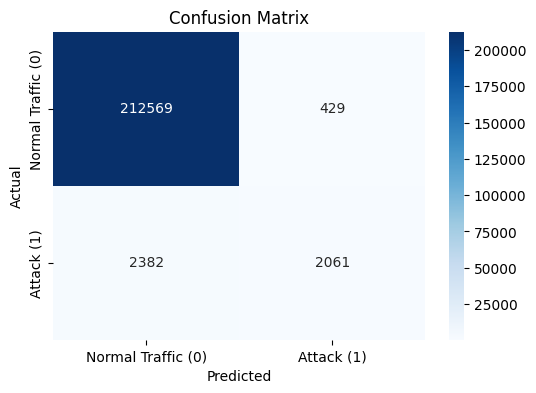

                precision    recall  f1-score   support

Normal Traffic       0.99      1.00      0.99    212998
        Attack       0.83      0.46      0.59      4443

      accuracy                           0.99    217441
     macro avg       0.91      0.73      0.79    217441
  weighted avg       0.99      0.99      0.99    217441



In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [32]:
import numpy as np
import pandas as pd

# Predictions on the (scaled) originals and adversarials
p_orig_attack = final_model.predict(X_test_attack, verbose=0).ravel()
p_adv_attack  = final_model.predict(X_attack_adv,  verbose=0).ravel()

orig_pred = (p_orig_attack > 0.5).astype(int)
adv_pred  = (p_adv_attack  > 0.5).astype(int)

# Masks for transitions
mask_1_to_0 = (orig_pred == 1) & (adv_pred == 0)  # attack → normal
mask_0_to_1 = (orig_pred == 0) & (adv_pred == 1)  # normal → attack (on the same attack samples)

n_1_to_0 = int(mask_1_to_0.sum())
n_0_to_1 = int(mask_0_to_1.sum())

# Optional: unchanged counts
n_1_to_1 = int(((orig_pred == 1) & (adv_pred == 1)).sum())
n_0_to_0 = int(((orig_pred == 0) & (adv_pred == 0)).sum())

total = len(orig_pred)

print(f"Total attack samples: {total}")
print(f"Flipped 1→0 (attack→normal): {n_1_to_0} ({n_1_to_0/total:.2%})")
print(f"Flipped 0→1 (normal→attack): {n_0_to_1} ({n_0_to_1/total:.2%})")
print(f"Stayed 1→1: {n_1_to_1} ({n_1_to_1/total:.2%})")
print(f"Stayed 0→0: {n_0_to_0} ({n_0_to_0/total:.2%})")

# Optional: a tidy 2×2 table of transitions
transition = pd.crosstab(pd.Series(orig_pred, name="orig"),
                         pd.Series(adv_pred,  name="adv"))
print("\nTransition table (orig → adv):\n", transition)


Total attack samples: 4443
Flipped 1→0 (attack→normal): 2144 (48.26%)
Flipped 0→1 (normal→attack): 7 (0.16%)
Stayed 1→1: 2054 (46.23%)
Stayed 0→0: 238 (5.36%)

Transition table (orig → adv):
 adv      0     1
orig            
0      238     7
1     2144  2054


In [35]:
import numpy as np
import pandas as pd

column_names = selected_features

# --- Predict on scaled inputs (no inverse-transform for prediction) ---
p_orig_attack = final_model.predict(X_test_attack, verbose=0).ravel()
p_adv_attack  = final_model.predict(X_attack_adv,  verbose=0).ravel()

orig_pred = (p_orig_attack > 0.5).astype(int)
adv_pred  = (p_adv_attack  > 0.5).astype(int)

# --- Find flips: 1 -> 0 ---
idx_flip = np.where((orig_pred == 1) & (adv_pred == 0))[0]
print(f"Total attack samples: {len(X_test_attack)}")
print(f"Flipped (1→0): {len(idx_flip)}")

if idx_flip.size == 0:
    print("No examples flipped from attack (1) to normal (0).")
else:
    # show up to N examples
    N = 10
    idx_show = idx_flip[:N]

    # inverse-transform ONLY FOR DISPLAY
    scaler_display = scaler if 'scaler' in locals() else scaler_full
    X_orig_disp = scaler_display.inverse_transform(X_test_attack[idx_show])
    X_adv_disp  = scaler_display.inverse_transform(X_attack_adv[idx_show])

    # predictions (from the already-computed probs)
    y_pred_orig = orig_pred[idx_show]
    y_pred_adv  = adv_pred[idx_show]

    # build tables like before
    df_original = pd.DataFrame(X_orig_disp, columns=column_names)
    df_original["Prediction"] = y_pred_orig

    df_adversarial = pd.DataFrame(X_adv_disp, columns=column_names)
    df_adversarial["Prediction"] = y_pred_adv

    # display settings (same style as earlier)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.precision', 6)
    pd.set_option('display.width', 100)

    print("\n🟦 Original Attack Samples (that later flipped 1→0):\n")
    print(df_original)

    print("\n🟥 Corresponding Adversarial Samples:\n")
    print(df_adversarial)

# 🟩 Normal samples for comparison (first up to 10)
n_norm = min(10, len(X_test_normal))
X_norm_scaled = X_test_normal[:n_norm]  # already scaled
scaler_display = scaler if 'scaler' in locals() else scaler_full

# Inverse-transform for display only
X_norm_disp = scaler_display.inverse_transform(X_norm_scaled)

# Predictions on scaled inputs
y_pred_norm = (final_model.predict(X_norm_scaled, verbose=0).ravel() > 0.5).astype(int)

# Build table
df_normal = pd.DataFrame(X_norm_disp, columns=column_names)
df_normal["Prediction"] = y_pred_norm

print("\n🟩 Normal Samples (benign) for comparison:\n")
print(df_normal)


Total attack samples: 4443
Flipped (1→0): 2144

🟦 Original Attack Samples (that later flipped 1→0):

    sttl  ct_state_ttl  dmeansz         Sload    ackdat   dttl   sbytes    synack    tcprtt  \
0  254.0           2.0      0.0  4.560000e+07  0.000000    0.0    114.0  0.000000  0.000000   
1  254.0           2.0      0.0  5.066666e+07  0.000000    0.0    114.0  0.000000  0.000000   
2  254.0           2.0      0.0  4.145454e+07  0.000000    0.0    114.0  0.000000  0.000000   
3  254.0           2.0      0.0  5.700000e+07  0.000000    0.0    114.0  0.000000  0.000000   
4  254.0           2.0      0.0  6.514286e+07  0.000000    0.0    114.0  0.000000  0.000000   
5   62.0           1.0    375.0  2.141865e+03  0.055738  252.0    364.0  0.087962  0.143700   
6   62.0           1.0     75.0  1.058107e+05  0.097859  252.0  48383.0  0.075140  0.172999   
7  254.0           2.0      0.0  6.109091e+07  0.000000    0.0    168.0  0.000000  0.000000   
8  254.0           2.0      0.0  4.560000e+0

# FGSM with real-life values 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
X_df = data.drop(columns=['attack_cat', 'Label']) # Keep as DataFrame
y = data['Label'].values

X_trainval_df, X_test_df, y_trainval, y_test = train_test_split(
    X_df, y, test_size=0.2, stratify=y, random_state=1
)

selected_features = ['sttl', 'ct_state_ttl', 'dmeansz', 'Sload', 'ackdat', 'dttl', 'sbytes', 
 'synack', 'tcprtt', 'smeansz', 'Dload', 'state', 'dbytes', 'Dintpkt', 'dur', 'Ltime', 'Stime', 'ct_srv_dst']

Xtr_sel = X_trainval_df[selected_features].values
Xte_sel = X_test_df[selected_features].values

scaler_full = StandardScaler().fit(Xtr_sel)
Xtr_sel = scaler_full.transform(Xtr_sel)
Xte_sel = scaler_full.transform(Xte_sel)

In [10]:
import numpy as np

def enforce_unsw_constraints_in_scaled_space(X_scaled, scaler, feature_order):
    """
    Enforce UNSW-NB15 constraints directly in scaled space:
      - sttl:    integer in [0, 255]
      - sbytes:  integer >= 1   (force > 0 as requested)
      - smeansz: float  > 0
      - Sload:   recompute consistently as 8*sbytes/dur when dur>0, else 0; clamp >= 0
    Everything else untouched.
    Requires a StandardScaler-like scaler (mean_, scale_).
    """
    Xs = np.asarray(X_scaled, dtype=np.float64, order="C")

    if not hasattr(scaler, "mean_") or not hasattr(scaler, "scale_"):
        raise ValueError("This function expects a StandardScaler (with mean_ and scale_).")

    mean = np.asarray(scaler.mean_, dtype=np.float64)
    scale = np.asarray(scaler.scale_, dtype=np.float64)
    col = {c: i for i, c in enumerate(feature_order)}

    def _to_orig(z, j):     return z * scale[j] + mean[j]
    def _to_scaled(x, j):   return (x - mean[j]) / scale[j]
    def _rint_clip_nonneg(x, lo=0):  # round to nearest int, then clip >= lo
        x = np.rint(x)
        return np.clip(x, lo, None)

    eps_pos = 1e-9  # for strict positivity

    # ---- sttl: integer [0,255] ----
    if 'sttl' in col:
        j = col['sttl']
        x = _to_orig(Xs[:, j], j)
        x = np.clip(np.rint(x), 0, 255)   # exact integer
        Xs[:, j] = _to_scaled(x, j)

    # ---- sbytes: integer >= 1 ----
    j_sbytes = col.get('sbytes', None)
    if j_sbytes is not None:
        x = _to_orig(Xs[:, j_sbytes], j_sbytes)
        x = _rint_clip_nonneg(x, lo=1)    # force > 0 → min 1
        Xs[:, j_sbytes] = _to_scaled(x, j_sbytes)
        sbytes_orig = x
    else:
        sbytes_orig = None

    # ---- smeansz: strictly > 0 ----
    if 'smeansz' in col:
        j = col['smeansz']
        x = _to_orig(Xs[:, j], j)
        x = np.maximum(x, eps_pos)
        Xs[:, j] = _to_scaled(x, j)

    # ---- Sload: recompute from sbytes & dur when possible, clamp >= 0 ----
    j_sload = col.get('Sload', None)
    j_dur   = col.get('dur',   None)

    if (j_sload is not None) and (sbytes_orig is not None) and (j_dur is not None):
        dur_orig = _to_orig(Xs[:, j_dur], j_dur)
        # safe denom: if dur <= 0 -> set rate = 0
        with np.errstate(divide='ignore', invalid='ignore'):
            sload_new = np.where(dur_orig > 0.0, 8.0 * sbytes_orig / dur_orig, 0.0)
        sload_new = np.maximum(sload_new, 0.0)
        Xs[:, j_sload] = _to_scaled(sload_new, j_sload)
    elif j_sload is not None:
        # If we can't recompute, at least clamp Sload >= 0
        x = _to_orig(Xs[:, j_sload], j_sload)
        x = np.maximum(x, 0.0)
        Xs[:, j_sload] = _to_scaled(x, j_sload)

    return Xs


In [39]:
import tensorflow as tf
import numpy as np

# ---- Split attack/normal on the (scaled) test set ----
X_test_attack = Xte_sel[y_test == 1]
y_test_attack = y_test[y_test == 1]

X_test_normal = Xte_sel[y_test == 0]
y_test_normal = y_test[y_test == 0]

# Convert to tensors
X_attack_tensor = tf.convert_to_tensor(X_test_attack, dtype=tf.float32)
y_attack_tensor = tf.convert_to_tensor(y_test_attack.astype(np.float32))

# Feature order & scaler used in training
feature_order = selected_features  # e.g. ['Offset','sTtl','sMeanPktSz','sHops','State']
scaler_project = scaler if 'scaler' in locals() else scaler_full
feat_idx = {c: i for i, c in enumerate(feature_order)}

# ---- FGSM with feature mask (exclude 'State') ----
def fgsm_attack(model, X, y, epsilon, feature_mask=None):
    with tf.GradientTape() as tape:
        tape.watch(X)
        predictions = model(X)
        loss = tf.keras.losses.binary_crossentropy(tf.reshape(y, (-1, 1)), predictions)
    gradient = tape.gradient(loss, X)

    # Optional debug
    print("Gradient stats:")
    print("  Min:", tf.reduce_min(gradient).numpy())
    print("  Max:", tf.reduce_max(gradient).numpy())
    print("  Mean:", tf.reduce_mean(gradient).numpy())
    print("Avg abs gradient per feature:", tf.reduce_mean(tf.abs(gradient), axis=0).numpy())

    signed_grad = tf.sign(gradient)
    if feature_mask is not None:
        mask = tf.reshape(tf.convert_to_tensor(feature_mask, dtype=X.dtype), (1, -1))
        signed_grad = signed_grad * mask  # broadcast across batch

    X_adv = X + epsilon * signed_grad
    return X_adv.numpy()

# ---- FGSM with UNSW-NB15 realism mask (using your selected_features) ----
feat_idx = {c: i for i, c in enumerate(selected_features)}

# Start with all features frozen (0)
mask_vec = np.zeros(X_test_attack.shape[1], dtype=np.float32)

# Whitelist the 4 source-controllable features
for feat in ['sttl', 'Sload', 'sbytes', 'smeansz']:
    if feat in feat_idx:
        mask_vec[feat_idx[feat]] = 1.0

epsilon = 0.3
X_attack_adv = fgsm_attack(
    final_model,
    X_attack_tensor,
    y_attack_tensor,
    epsilon=epsilon,
    feature_mask=mask_vec
)


# X_attack_adv = enforce_realistic_values_and_rescale(
#     X_attack_adv, X_test_attack, scaler_project, feature_order
# )

X_attack_adv = enforce_unsw_constraints_in_scaled_space(
    X_attack_adv, scaler_project, selected_features
)

# ---- Rebuild the (scaled) test set and labels ----
X_test_combined = np.vstack((X_test_normal, X_attack_adv))
y_test_combined = np.hstack((y_test_normal, y_test_attack))

from sklearn.utils import shuffle
X_test_adv_final, y_test_adv_final = shuffle(
    X_test_combined, y_test_combined, random_state=1
)


Gradient stats:
  Min: -3.9291232
  Max: 4.3569474
  Mean: -0.008619775
Avg abs gradient per feature: [0.03051898 0.01534259 0.0609132  0.01201133 0.01668486 0.01105658
 0.02145385 0.02034364 0.01009674 0.04133483 0.01569602 0.03373316
 0.0441159  0.00819941 0.1075601  0.05633737 0.05742814 0.17042114]


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred = final_model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_adv_final, y_pred)
precision = precision_score(y_test_adv_final, y_pred, average='weighted')
recall = recall_score(y_test_adv_final, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


6796/6796 ━━━━━━━━━━━━━━━━━━━━ 6s 817us/step
Test Accuracy: 99.66%
Test Precision: 99.67%
Test Recall: 99.66%


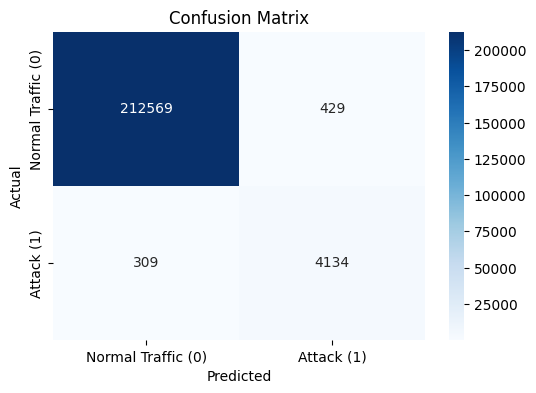

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    212998
        Attack       0.91      0.93      0.92      4443

      accuracy                           1.00    217441
     macro avg       0.95      0.96      0.96    217441
  weighted avg       1.00      1.00      1.00    217441



In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [42]:
import numpy as np
import pandas as pd

column_names = selected_features

# --- Predict on scaled inputs (no inverse-transform for prediction) ---
p_orig_attack = final_model.predict(X_test_attack, verbose=0).ravel()
p_adv_attack  = final_model.predict(X_attack_adv,  verbose=0).ravel()

orig_pred = (p_orig_attack > 0.5).astype(int)
adv_pred  = (p_adv_attack  > 0.5).astype(int)

# --- Find flips: 1 -> 0 ---
idx_flip = np.where((orig_pred == 1) & (adv_pred == 0))[0]
print(f"Total attack samples: {len(X_test_attack)}")
print(f"Flipped (1→0): {len(idx_flip)}")

if idx_flip.size == 0:
    print("No examples flipped from attack (1) to normal (0).")
else:
    # show up to N examples
    N = 10
    idx_show = idx_flip[:N]

    # inverse-transform ONLY FOR DISPLAY
    scaler_display = scaler if 'scaler' in locals() else scaler_full
    X_orig_disp = scaler_display.inverse_transform(X_test_attack[idx_show])
    X_adv_disp  = scaler_display.inverse_transform(X_attack_adv[idx_show])

    # predictions (from the already-computed probs)
    y_pred_orig = orig_pred[idx_show]
    y_pred_adv  = adv_pred[idx_show]

    # build tables like before
    df_original = pd.DataFrame(X_orig_disp, columns=column_names)
    df_original["Prediction"] = y_pred_orig

    df_adversarial = pd.DataFrame(X_adv_disp, columns=column_names)
    df_adversarial["Prediction"] = y_pred_adv

    # display settings (same style as earlier)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.precision', 6)
    pd.set_option('display.width', 100)

    print("\n🟦 Original Attack Samples (that later flipped 1→0):\n")
    print(df_original)

    print("\n🟥 Corresponding Adversarial Samples:\n")
    print(df_adversarial)

# 🟩 Normal samples for comparison (first up to 10)
n_norm = min(10, len(X_test_normal))
X_norm_scaled = X_test_normal[:n_norm]  # already scaled
scaler_display = scaler if 'scaler' in locals() else scaler_full

# Inverse-transform for display only
X_norm_disp = scaler_display.inverse_transform(X_norm_scaled)

# Predictions on scaled inputs
y_pred_norm = (final_model.predict(X_norm_scaled, verbose=0).ravel() > 0.5).astype(int)

# Build table
df_normal = pd.DataFrame(X_norm_disp, columns=column_names)
df_normal["Prediction"] = y_pred_norm

print("\n🟩 Normal Samples (benign) for comparison:\n")
print(df_normal)


Total attack samples: 4443
Flipped (1→0): 80

🟦 Original Attack Samples (that later flipped 1→0):

    sttl  ct_state_ttl  dmeansz         Sload    ackdat   dttl  sbytes    synack    tcprtt  \
0  254.0           2.0      0.0  6.109091e+07  0.000000    0.0   168.0  0.000000  0.000000   
1  254.0           1.0     44.0  8.035181e+03  0.051902  252.0   566.0  0.066502  0.118404   
2  254.0           2.0      0.0  2.836364e+07  0.000000    0.0    78.0  0.000000  0.000000   
3  254.0           1.0     45.0  9.680871e+03  0.061410  252.0   490.0  0.071406  0.132816   
4  254.0           1.0     45.0  1.527570e+04  0.038910  252.0   756.0  0.083052  0.121962   
5  254.0           1.0     81.0  1.220943e+04  0.032274  252.0   994.0  0.082042  0.114316   
6  254.0           1.0     44.0  6.769333e+03  0.068052  252.0   756.0  0.077196  0.145248   
7  254.0           2.0      0.0  5.200000e+07  0.000000    0.0    78.0  0.000000  0.000000   
8  254.0           1.0     94.0  1.434518e+04  0.072835

# ZOO

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

# ---------- Utilities ----------
def predict_proba(model, X):
    """Return P(y=1) as a flat numpy array."""
    return model.predict(X, verbose=0).ravel()

def bce_loss(p, y):
    """Binary cross-entropy (elementwise) with clipping for numerical stability."""
    eps = 1e-7
    p = np.clip(p, eps, 1 - eps)
    return -(y * np.log(p) + (1 - y) * np.log(1 - p))

def loss_at_x(model, x, y_scalar):
    """Loss at a single point x (1D) for label y in {0,1}."""
    p = predict_proba(model, x[None, :])[0]
    return bce_loss(p, y_scalar)

def finite_diff_grad(model, x, y_scalar, h=1e-3):
    """
    Central-difference gradient of loss wrt x.
    Uses 2*d queries per call (d = number of features).
    """
    d = x.shape[0]
    batch_plus = np.repeat(x[None, :], d, axis=0)
    batch_minus = batch_plus.copy()
    for i in range(d):
        batch_plus[i, i] += h
        batch_minus[i, i] -= h

    p_plus = predict_proba(model, batch_plus)
    p_minus = predict_proba(model, batch_minus)
    L_plus = bce_loss(p_plus, np.full(d, y_scalar))
    L_minus = bce_loss(p_minus, np.full(d, y_scalar))

    # central difference derivative dL/dx_i ≈ (L(x+h e_i) - L(x-h e_i)) / (2h)
    grad = (L_plus - L_minus) / (2.0 * h)
    queries = 2 * d
    return grad, queries

def project_linf(x0, x, eps):
    """Project x to the Linf ball around x0 with radius eps."""
    return np.clip(x, x0 - eps, x0 + eps)

def project_l2(x0, x, eps):
    """Project x to the L2 ball around x0 with radius eps."""
    delta = x - x0
    norm = np.linalg.norm(delta, ord=2)
    if norm > eps:
        delta = delta * (eps / (norm + 1e-12))
    return x0 + delta

# ---------- Core ZOO attacker (single example) ----------
def zoo_attack_single(
    model,
    x0,
    y_true,
    steps=300,
    lr=0.05,
    h=1e-3,
    eps=0.5,
    norm="linf",          # "linf" or "l2"
    targeted=None,        # None for untargeted; otherwise target label in {0,1}
    clip_min=None,
    clip_max=None,
    early_stop=True
):
    """
    Runs ZOO on one sample.
    - Untargeted: ascend BCE loss for the true label until misclassification.
    - Targeted:   descend BCE loss for the chosen target label until classified as target.

    Returns: x_adv, success(bool), queries(int), iters(int)
    """
    x = x0.copy()
    queries = 0
    d = x.size

    # Choose projector
    projector = project_linf if norm == "linf" else project_l2

    # Initial check
    p0 = predict_proba(model, x[None, :])[0]; queries += 1
    y_pred0 = int(p0 > 0.5)
    already_wrong = (y_pred0 != y_true)
    if targeted is None and already_wrong:
        return x, True, queries, 0  # already misclassified

    for t in range(1, steps + 1):
        # For targeted, define loss towards the target; for untargeted, towards the true label
        label_for_loss = targeted if targeted is not None else y_true

        # Zeroth-order gradient estimate of d(loss)/dx
        grad, q = finite_diff_grad(model, x, label_for_loss, h=h)
        queries += q

        # Update rule: untargeted -> ascend; targeted -> descend
        direction = +1.0 if targeted is None else -1.0
        x = x + direction * lr * grad

        # Project to epsilon-ball around original point
        x = projector(x0, x, eps)

        # Optional: keep within observed data range to avoid extreme z-scores
        if (clip_min is not None) and (clip_max is not None):
            x = np.minimum(np.maximum(x, clip_min), clip_max)

        # Check success condition
        p = predict_proba(model, x[None, :])[0]; queries += 1
        y_pred = int(p > 0.5)
        success = (y_pred != y_true) if targeted is None else (y_pred == targeted)

        if early_stop and success:
            return x, True, queries, t

    # End of budget
    p = predict_proba(model, x[None, :])[0]; queries += 1
    y_pred = int(p > 0.5)
    success = (y_pred != y_true) if targeted is None else (y_pred == targeted)
    return x, success, queries, steps

# ---------- Convenience: attack a batch and summarize ----------
def run_zoo_attack(
    model,
    X,
    y,
    X_train_for_bounds=None,     # e.g., Xtr_sel to bound to observed range
    max_samples=100,
    eps=0.5,
    norm="linf",
    steps=300,
    lr=0.05,
    h=1e-3,
    targeted=None,
    only_on_correct=True,
    random_state=0
):
    rng = np.random.default_rng(random_state)

    # Bounds from training data (optional but recommended for tabular)
    if X_train_for_bounds is not None:
        clip_min = X_train_for_bounds.min(axis=0)
        clip_max = X_train_for_bounds.max(axis=0)
    else:
        clip_min = clip_max = None

    # Decide which indices to attack
    y_pred_all = (predict_proba(model, X) > 0.5).astype(int)
    if only_on_correct:
        candidates = np.where(y_pred_all == y)[0]
    else:
        candidates = np.arange(len(y))
    rng.shuffle(candidates)
    idxs = candidates[:max_samples]

    successes = []
    queries_list = []
    iters_list = []
    X_adv = np.copy(X)

    for idx in idxs:
        x0 = X[idx]
        y_true = int(y[idx])
        x_adv, success, q, iters = zoo_attack_single(
            model=model,
            x0=x0,
            y_true=y_true,
            steps=steps,
            lr=lr,
            h=h,
            eps=eps,
            norm=norm,
            targeted=targeted,
            clip_min=clip_min,
            clip_max=clip_max,
            early_stop=True
        )
        X_adv[idx] = x_adv
        successes.append(success)
        queries_list.append(q)
        iters_list.append(iters)

    # Metrics
    success_rate = np.mean(successes) if len(successes) else 0.0
    avg_queries = np.mean(queries_list) if queries_list else 0
    avg_iters = np.mean(iters_list) if iters_list else 0

    # Evaluate accuracy before/after (on attacked subset)
    acc_before = accuracy_score(y[idxs], y_pred_all[idxs])
    acc_after = accuracy_score(y[idxs], (predict_proba(model, X_adv[idxs]) > 0.5).astype(int))

    summary = {
        "num_attacked": len(idxs),
        "only_on_correct": only_on_correct,
        "targeted": targeted,
        "eps": eps,
        "norm": norm,
        "steps": steps,
        "lr": lr,
        "h": h,
        "success_rate": float(success_rate),
        "avg_queries": float(avg_queries),
        "avg_iters": float(avg_iters),
        "acc_before_on_subset": float(acc_before),
        "acc_after_on_subset": float(acc_after),
        "attacked_indices": idxs,
        "successes_bool": np.array(successes, dtype=bool),
        "queries_each": np.array(queries_list, dtype=int),
        "iters_each": np.array(iters_list, dtype=int),
        "X_adv": X_adv,  # full array with adversarial versions at attacked indices
    }
    return summary

In [16]:
# --- 1) Slice out ATTACK samples (y == 1) from your standardized test set ---
attack_mask = (y_test.astype(int) == 1)
X_attack = Xte_sel[attack_mask]
y_attack = y_test[attack_mask].astype(int)

print(f"Attack samples in test set: {len(y_attack)}")

Attack samples in test set: 4443


In [45]:
# Baseline detection on those attack samples
pred_attack_before = (final_model.predict(X_attack, verbose=0).ravel() > 0.5).astype(int)
tpr_before = (pred_attack_before == 1).mean()  # detection rate among attack samples
print(f"Baseline detection rate on attack samples (TPR): {tpr_before:.3f}")

# --- 2) Run TARGETED ZOO to force label 0 (normal) on attack samples only ---
zoo_attack_on_attacks = run_zoo_attack(
    model=final_model,
    X=X_attack,
    y=y_attack,
    X_train_for_bounds=None,   # black-box friendly; use Xtr_sel if you're OK with train-derived bounds
    targeted=0,                # <- IMPORTANT: push to normal class
    only_on_correct=True,      # only try to evade ones currently detected as attack
    max_samples=min(4443, len(y_attack)),  # cap if large set
    eps=0.5,                   # Linf radius in STANDARDIZED units
    norm="linf",
    steps=300,
    lr=0.1,
    h=1e-3,
    random_state=42
)

print("==== ZOO on attack samples (targeted to NORMAL / 0) ====")
for k, v in zoo_attack_on_attacks.items():
    if k in {"X_adv", "attacked_indices", "successes_bool", "queries_each", "iters_each"}:
        continue
    print(f"{k}: {v}")

# --- 3) Evaluate evasion on attacked subset and overall attack set ---
X_attack_adv = zoo_attack_on_attacks["X_adv"]  # same shape as X_attack; attacked indices modified
attacked_local_idx = zoo_attack_on_attacks["attacked_indices"]
success_flags = zoo_attack_on_attacks["successes_bool"]
queries_each = zoo_attack_on_attacks["queries_each"]

# Predictions AFTER on attack-only array (includes both attacked & untouched elements)
pred_attack_after = (final_model.predict(X_attack_adv, verbose=0).ravel() > 0.5).astype(int)
tpr_after = (pred_attack_after == 1).mean()
evasion_rate_all_attacks = (pred_attack_after == 0).mean()

# Evasion rate restricted to actually ATTACKED samples
evasion_rate_attacked = success_flags.mean() if len(success_flags) else 0.0
avg_queries_attacked = queries_each.mean() if len(queries_each) else 0.0

print(f"\n--- Evasion results ---")
print(f"Detection rate on attack samples BEFORE: {tpr_before:.3f}")
print(f"Detection rate on attack samples AFTER:  {tpr_after:.3f}")
print(f"Evasion rate among ALL attack samples:   {evasion_rate_all_attacks:.3f}")
print(f"Evasion rate among ATTACKED subset:      {evasion_rate_attacked:.3f}")
print(f"Avg queries per attacked sample:         {avg_queries_attacked:.1f}")

# --- 4) (Optional) Put adversarial attacks back into the FULL test matrix ---
# This is handy if you want to re-run a full classification report after evasion.
Xte_adv_full = Xte_sel.copy()
global_attack_indices = np.where(attack_mask)[0]
Xte_adv_full[global_attack_indices] = X_attack_adv

# Example: full post-attack report
test_preds_after = (final_model.predict(Xte_adv_full, verbose=0).ravel() > 0.5).astype(int)

from sklearn.metrics import classification_report
print("\nFinal Test Set Report AFTER targeted ZOO on attack samples:")
print(classification_report(y_test, test_preds_after, zero_division=0))


Baseline detection rate on attack samples (TPR): 0.945
==== ZOO on attack samples (targeted to NORMAL / 0) ====
num_attacked: 4198
only_on_correct: True
targeted: 0
eps: 0.5
norm: linf
steps: 300
lr: 0.1
h: 0.001
success_rate: 0.9192472606002858
avg_queries: 1073.4197236779419
avg_iters: 28.98213434969033
acc_before_on_subset: 1.0
acc_after_on_subset: 0.08075273939971415

--- Evasion results ---
Detection rate on attack samples BEFORE: 0.945
Detection rate on attack samples AFTER:  0.076
Evasion rate among ALL attack samples:   0.924
Evasion rate among ATTACKED subset:      0.919
Avg queries per attacked sample:         1073.4

Final Test Set Report AFTER targeted ZOO on attack samples:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    212998
           1       0.44      0.08      0.13      4443

    accuracy                           0.98    217441
   macro avg       0.71      0.54      0.56    217441
weighted avg       0.97      0.9

In [ ]:
 0       0.98      1.00      0.99    212998
           1       0.44      0.08      0.13      4443

    accuracy                           0.98    217441
   macro avg       0.71      0.54      0.56    217441
weighted avg       0.97      0.98      0.97    217441

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
# y_pred = final_model.predict(X_test_adv_final)
y_pred = test_preds_after

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")

Test Accuracy: 97.92%
Test Precision: 97.00%
Test Recall: 97.92%


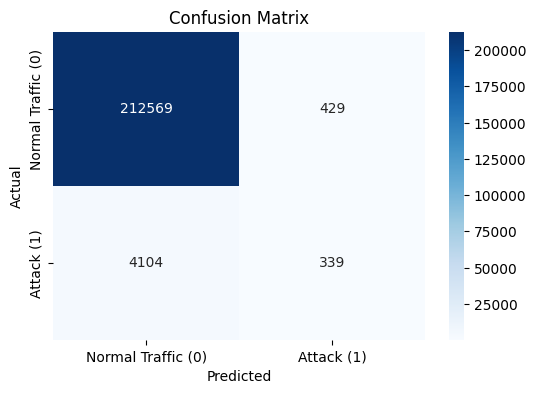

                precision    recall  f1-score   support

Normal Traffic       0.98      1.00      0.99    212998
        Attack       0.44      0.08      0.13      4443

      accuracy                           0.98    217441
     macro avg       0.71      0.54      0.56    217441
  weighted avg       0.97      0.98      0.97    217441



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_pred, target_names=['Normal Traffic', 'Attack']))


In [49]:
import numpy as np
import pandas as pd

# --- 1) Collect only the successfully flipped samples (1 → 0) ---
success_mask = zoo_attack_on_attacks["successes_bool"]
attacked_idx = zoo_attack_on_attacks["attacked_indices"]
successful_local_idx = np.array(attacked_idx)[success_mask]

# Standardized (model-space) originals + adversarials for those successes
X_orig_success_std = X_attack[successful_local_idx]
X_adv_success_std  = zoo_attack_on_attacks["X_adv"][successful_local_idx]

# Sanity: keep only those that truly flipped 1->0 according to the model
pred_orig = (final_model.predict(X_orig_success_std, verbose=0).ravel() > 0.5).astype(int)
pred_adv  = (final_model.predict(X_adv_success_std,  verbose=0).ravel() > 0.5).astype(int)

flip_mask = (pred_orig == 1) & (pred_adv == 0)
X_orig_success_std = X_orig_success_std[flip_mask]
X_adv_success_std  = X_adv_success_std[flip_mask]
pred_orig = pred_orig[flip_mask]
pred_adv  = pred_adv[flip_mask]

# --- 2) Inverse-transform back to original feature units ---
# scaler_full was fit on the selected columns used by the model (Xtr_sel)
X_orig_success = scaler_full.inverse_transform(X_orig_success_std)
X_adv_success  = scaler_full.inverse_transform(X_adv_success_std)

# --- 3) Build DataFrames with your desired columns and formatting ---
cols = selected_features

def make_df(X, preds):
    df = pd.DataFrame(X, columns=cols)
    return df

df_orig = make_df(X_orig_success, pred_orig)
df_adv  = make_df(X_adv_success,  pred_adv)

# --- 4) Show up to 10 examples in your exact format ---
n_show = min(10, len(df_orig))

# display settings (same style as earlier)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 6)
pd.set_option('display.width', 100)

# print("\n🟦 Original Attack Samples (that later flipped 1→0):\n")
# print(df_original)

# print("\n🟥 Corresponding Adversarial Samples:\n")
# print(df_adversarial)

print("\n🟦 Original Attack Samples (that later flipped 1→0):\n")
print(df_orig.head(n_show).to_string(index=True))

print("\n🟥 Adversarial Counterparts:\n")
print(df_adv.head(n_show).to_string(index=True))



🟦 Original Attack Samples (that later flipped 1→0):

    sttl  ct_state_ttl  dmeansz         Sload    ackdat   dttl  sbytes    synack    tcprtt  smeansz         Dload  state  dbytes       Dintpkt       dur         Ltime         Stime  ct_srv_dst
0  254.0           2.0      0.0  4.145454e+07  0.000000    0.0   114.0  0.000000  0.000000     57.0      0.000000    6.0     0.0 -1.421085e-14  0.000011  1.421933e+09  1.421933e+09        12.0
1  254.0           2.0      0.0  8.914286e+07  0.000000    0.0   156.0  0.000000  0.000000     78.0      0.000000    6.0     0.0 -1.421085e-14  0.000007  1.421929e+09  1.421929e+09         2.0
2  254.0           2.0      0.0  1.140000e+08  0.000000    0.0   114.0  0.000000  0.000000     57.0      0.000000    6.0     0.0 -1.421085e-14  0.000004  1.421931e+09  1.421931e+09        13.0
3   62.0           2.0      0.0  7.272727e+07  0.000000    0.0   200.0  0.000000  0.000000    100.0      0.000000    6.0     0.0 -1.421085e-14  0.000011  1.421929e+09  1.4219

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score

# ---------- Constrained finite-diff (central) ----------
def finite_diff_grad_constrained(
    model,
    x,
    y_scalar,
    h,
    projector,             # function(x0, x, eps) -> projected x
    x0,
    eps,
    enforcer_batch,        # function(X_scaled_batch) -> X_scaled_batch_feasible
    clip_min=None,
    clip_max=None,
):
    """
    Central-difference gradient of loss wrt x, but every probe is projected and
    run through the feasibility enforcer before the model sees it.
    """
    d = x.shape[0]
    batch_plus = np.repeat(x[None, :], d, axis=0)
    batch_minus = batch_plus.copy()
    for i in range(d):
        batch_plus[i, i] += h
        batch_minus[i, i] -= h

    # Project probes to epsilon-ball and apply optional [clip_min, clip_max]
    batch_plus = projector(x0, batch_plus, eps)
    batch_minus = projector(x0, batch_minus, eps)
    if (clip_min is not None) and (clip_max is not None):
        batch_plus = np.minimum(np.maximum(batch_plus, clip_min), clip_max)
        batch_minus = np.minimum(np.maximum(batch_minus, clip_min), clip_max)

    # Enforce real-world constraints on the *batch* of probes
    batch_plus = enforcer_batch(batch_plus)
    batch_minus = enforcer_batch(batch_minus)

    p_plus = predict_proba(model, batch_plus)
    p_minus = predict_proba(model, batch_minus)

    L_plus = bce_loss(p_plus, np.full(d, y_scalar))
    L_minus = bce_loss(p_minus, np.full(d, y_scalar))

    grad = (L_plus - L_minus) / (2.0 * h)
    queries = 2 * d
    return grad, queries


# ---------- Single-example constrained ZOO ----------
def zoo_attack_single_constrained(
    model,
    x0_scaled,
    y_true,
    *,
    steps=300,
    lr=0.05,
    h=1e-3,
    eps=0.5,
    norm="linf",          # "linf" or "l2"
    targeted=None,        # None for untargeted; otherwise target label in {0,1}
    clip_min=None,
    clip_max=None,
    early_stop=True,
    # --- NEW: feasibility enforcer wiring ---
    scaler=None,
    feature_order=None,
    X_orig_scaled_ref=None,     # scaled original(s) used to pin immutable features (e.g., same row)
    enforcer_func=enforce_unsw_constraints_in_scaled_space,
):
    """
    Constrained ZOO:
      - Every step and probe stays inside the epsilon ball AND inside the
        real-world feasible set (via enforcer_func).
    Returns: x_adv_scaled, success(bool), queries(int), iters(int)
    """
    assert scaler is not None and feature_order is not None and X_orig_scaled_ref is not None, \
        "Provide scaler, feature_order, and X_orig_scaled_ref for constraint enforcement."

    # Build a *batch* enforcer that always uses the same original sample row
    # for non-attackable features (radiotap.*, etc.)
    def enforcer_batch(X_scaled_batch):
        # X_orig_scaled is repeated to match the batch shape
        X_orig_scaled = np.repeat(X_orig_scaled_ref[None, :], X_scaled_batch.shape[0], axis=0)
        return enforcer_func(X_scaled_batch, scaler, feature_order)

    x = x0_scaled.copy()
    queries = 0

    projector = project_linf if norm == "linf" else project_l2

    # Initial feasibility snap (optional but keeps x exactly feasible before starting)
    x = enforcer_batch(x[None, :])[0]

    # Initial check
    p0 = predict_proba(model, x[None, :])[0]; queries += 1
    y_pred0 = int(p0 > 0.5)
    already_wrong = (y_pred0 != y_true)
    if targeted is None and already_wrong:
        return x, True, queries, 0

    for t in range(1, steps + 1):
        label_for_loss = targeted if targeted is not None else y_true

        # Constrained finite-diff gradient
        grad, q = finite_diff_grad_constrained(
            model=model,
            x=x,
            y_scalar=label_for_loss,
            h=h,
            projector=projector,
            x0=x0_scaled,
            eps=eps,
            enforcer_batch=enforcer_batch,
            clip_min=clip_min,
            clip_max=clip_max,
        )
        queries += q

        # Update (ascend for untargeted, descend for targeted)
        direction = +1.0 if targeted is None else -1.0
        x = x + direction * lr * grad

        # Project to ε-ball
        x = projector(x0_scaled, x, eps)

        # Optional clip to observed range (still in scaled space)
        if (clip_min is not None) and (clip_max is not None):
            x = np.minimum(np.maximum(x, clip_min), clip_max)

        # Enforce physical/measurement constraints + rescale
        x = enforcer_batch(x[None, :])[0]

        # Success check
        p = predict_proba(model, x[None, :])[0]; queries += 1
        y_pred = int(p > 0.5)
        success = (y_pred != y_true) if targeted is None else (y_pred == targeted)
        if early_stop and success:
            return x, True, queries, t

    # Final check
    p = predict_proba(model, x[None, :])[0]; queries += 1
    y_pred = int(p > 0.5)
    success = (y_pred != y_true) if targeted is None else (y_pred == targeted)
    return x, success, queries, steps


# ---------- Batch convenience with constraints ----------
def run_zoo_attack_constrained(
    model,
    X_scaled,
    y,
    *,
    scaler,
    feature_order,
    X_orig_scaled=None,       # if None, we assume X_orig_scaled == X_scaled (same standardization pipeline)
    X_train_for_bounds=None,  # to compute clip_min/clip_max in scaled space (optional)
    max_samples=100,
    eps=0.5,
    norm="linf",
    steps=300,
    lr=0.05,
    h=1e-3,
    targeted=None,
    only_on_correct=True,
    random_state=0
):
    rng = np.random.default_rng(random_state)

    # Bounds in *scaled* space if provided (recommended on tabular)
    if X_train_for_bounds is not None:
        clip_min = X_train_for_bounds.min(axis=0)
        clip_max = X_train_for_bounds.max(axis=0)
    else:
        clip_min = clip_max = None

    if X_orig_scaled is None:
        X_orig_scaled = X_scaled

    # Decide which indices to attack
    y_pred_all = (predict_proba(model, X_scaled) > 0.5).astype(int)
    if only_on_correct:
        candidates = np.where(y_pred_all == y)[0]
    else:
        candidates = np.arange(len(y))
    rng.shuffle(candidates)
    idxs = candidates[:max_samples]

    successes = []
    queries_list = []
    iters_list = []
    X_adv_scaled = np.copy(X_scaled)

    for idx in tqdm(idxs, desc="ZOO attack", unit="sample"):
        x0 = X_scaled[idx]
        y_true = int(y[idx])

        # Single-row "original scaled" reference for immutable features
        x_orig_ref = X_orig_scaled[idx]

        x_adv, success, q, iters = zoo_attack_single_constrained(
            model=model,
            x0_scaled=x0,
            y_true=y_true,
            steps=steps,
            lr=lr,
            h=h,
            eps=eps,
            norm=norm,
            targeted=targeted,
            clip_min=clip_min,
            clip_max=clip_max,
            early_stop=True,
            scaler=scaler,
            feature_order=feature_order,
            X_orig_scaled_ref=x_orig_ref,
        )
        X_adv_scaled[idx] = x_adv
        successes.append(success)
        queries_list.append(q)
        iters_list.append(iters)

    # Metrics
    success_rate = float(np.mean(successes)) if len(successes) else 0.0
    avg_queries = float(np.mean(queries_list)) if queries_list else 0.0
    avg_iters = float(np.mean(iters_list)) if iters_list else 0.0

    acc_before = accuracy_score(y[idxs], y_pred_all[idxs])
    acc_after = accuracy_score(y[idxs], (predict_proba(model, X_adv_scaled[idxs]) > 0.5).astype(int))

    summary = {
        "num_attacked": len(idxs),
        "only_on_correct": only_on_correct,
        "targeted": targeted,
        "eps": eps,
        "norm": norm,
        "steps": steps,
        "lr": lr,
        "h": h,
        "success_rate": success_rate,
        "avg_queries": avg_queries,
        "avg_iters": avg_iters,
        "acc_before_on_subset": float(acc_before),
        "acc_after_on_subset": float(acc_after),
        "attacked_indices": idxs,
        "successes_bool": np.array(successes, dtype=bool),
        "queries_each": np.array(queries_list, dtype=int),
        "iters_each": np.array(iters_list, dtype=int),
        "X_adv": X_adv_scaled.astype(np.float32),
    }
    return summary


In [32]:
# ---------- Single-example constrained ZOO (updated to match enforce_unsw_constraints_in_scaled_space) ----------
def zoo_attack_single_constrained(
    model,
    x0_scaled,
    y_true,
    *,
    steps=300,
    lr=0.05,
    h=1e-3,
    eps=0.5,
    norm="linf",          # "linf" or "l2"
    targeted=None,        # None for untargeted; otherwise target label in {0,1}
    clip_min=None,
    clip_max=None,
    early_stop=True,
    # --- NEW: feasibility enforcer wiring ---
    scaler=None,
    feature_order=None,
    X_orig_scaled_ref=None,     # scaled original(s) used to pin immutable features (e.g., same row)
    enforcer_func=enforce_unsw_constraints_in_scaled_space,
    # --- NEW: immutables and control flag ---
    immutable_mask=None,        # 1D array same length as x0_scaled: 1.0 == keep immutable (do not change)
    enforce_constraints=True,
):
    """
    Constrained ZOO:
      - Every step and probe stays inside the epsilon ball AND inside the
        real-world feasible set (via enforcer_func).
      - Supports immutable_mask (features that must remain equal to the original).
    Returns: x_adv_scaled, success(bool), queries(int), iters(int)
    """
    assert scaler is not None and feature_order is not None and X_orig_scaled_ref is not None, \
        "Provide scaler, feature_order, and X_orig_scaled_ref for constraint enforcement."

    x = x0_scaled.copy()
    queries = 0
    d = x.size

    # Validate immutable_mask if provided
    if immutable_mask is not None:
        immutable_mask = np.asarray(immutable_mask, dtype=float).ravel()
        if immutable_mask.shape[0] != d:
            raise ValueError("immutable_mask must have same length as x0_scaled")

    projector = project_linf if norm == "linf" else project_l2

    # Build a *batch* enforcer that always uses the same original sample row
    # for immutable features. The enforcer_func is optional (controlled by enforce_constraints).
    def enforcer_batch(X_scaled_batch):
        # X_orig_scaled is repeated to match the batch shape
        X_orig_scaled = np.repeat(X_orig_scaled_ref[None, :], X_scaled_batch.shape[0], axis=0)

        if enforce_constraints and (enforcer_func is not None):
            # Match your enforcer signature: (X_scaled, scaler, feature_order)
            X_enforced = enforcer_func(X_scaled_batch, scaler, feature_order)
        else:
            # No enforcement requested: just use the batch as-is
            X_enforced = X_scaled_batch.copy()

        # Re-apply immutables: keep original x_orig entries for immutable fields
        if immutable_mask is not None:
            imm_bool = (immutable_mask == 1.0)
            if imm_bool.any():
                # Broadcast original values into the enforced batch
                X_enforced[:, imm_bool] = X_orig_scaled[:, imm_bool]

        return X_enforced

    # Initial feasibility snap (optional but keeps x exactly feasible before starting)
    x = enforcer_batch(x[None, :])[0]

    # Initial check
    p0 = predict_proba(model, x[None, :])[0]; queries += 1
    y_pred0 = int(p0 > 0.5)
    already_wrong = (y_pred0 != y_true)
    if targeted is None and already_wrong:
        return x, True, queries, 0

    for t in range(1, steps + 1):
        label_for_loss = targeted if targeted is not None else y_true

        # Constrained finite-diff gradient
        grad, q = finite_diff_grad_constrained(
            model=model,
            x=x,
            y_scalar=label_for_loss,
            h=h,
            projector=projector,
            x0=x0_scaled,
            eps=eps,
            enforcer_batch=enforcer_batch,
            clip_min=clip_min,
            clip_max=clip_max,
        )
        queries += q

        # Update (ascend for untargeted, descend for targeted)
        direction = +1.0 if targeted is None else -1.0
        x = x + direction * lr * grad

        # Project to ε-ball
        x = projector(x0_scaled, x, eps)

        # Optional clip to observed range (still in scaled space)
        if (clip_min is not None) and (clip_max is not None):
            x = np.minimum(np.maximum(x, clip_min), clip_max)

        # Enforce physical/measurement constraints + re-apply immutables via enforcer_batch
        x = enforcer_batch(x[None, :])[0]

        # Success check
        p = predict_proba(model, x[None, :])[0]; queries += 1
        y_pred = int(p > 0.5)
        success = (y_pred != y_true) if targeted is None else (y_pred == targeted)
        if early_stop and success:
            return x, True, queries, t

    # Final check
    p = predict_proba(model, x[None, :])[0]; queries += 1
    y_pred = int(p > 0.5)
    success = (y_pred != y_true) if targeted is None else (y_pred == targeted)
    return x, success, queries, steps


# ---------- Batch convenience with constraints (forwards enforcer_func and immutable_mask) ----------
def run_zoo_attack_constrained(
    model,
    X_scaled,
    y,
    *,
    scaler,
    feature_order,
    X_orig_scaled=None,       # if None, we assume X_orig_scaled == X_scaled (same standardization pipeline)
    X_train_for_bounds=None,  # to compute clip_min/clip_max in scaled space (optional)
    max_samples=100,
    eps=0.5,
    norm="linf",
    steps=300,
    lr=0.05,
    h=1e-3,
    targeted=None,
    only_on_correct=True,
    immutable_mask=None,
    enforce_constraints=True,
    enforcer_func=enforce_unsw_constraints_in_scaled_space,
    random_state=0
):
    rng = np.random.default_rng(random_state)

    # Bounds in *scaled* space if provided (recommended on tabular)
    if X_train_for_bounds is not None:
        clip_min = X_train_for_bounds.min(axis=0)
        clip_max = X_train_for_bounds.max(axis=0)
    else:
        clip_min = clip_max = None

    if X_orig_scaled is None:
        X_orig_scaled = X_scaled

    # Decide which indices to attack
    y_pred_all = (predict_proba(model, X_scaled) > 0.5).astype(int)
    if only_on_correct:
        candidates = np.where(y_pred_all == y)[0]
    else:
        candidates = np.arange(len(y))
    rng.shuffle(candidates)
    idxs = candidates[:max_samples]

    successes = []
    queries_list = []
    iters_list = []
    X_adv_scaled = np.copy(X_scaled)

    # Validate immutable_mask if provided (must be 1D of length d)
    if immutable_mask is not None:
        immutable_mask = np.asarray(immutable_mask, dtype=float).ravel()
        if immutable_mask.shape[0] != X_scaled.shape[1]:
            raise ValueError("immutable_mask must have same length as number of features")

    for idx in tqdm(idxs, desc="ZOO attack", unit="sample"):
        x0 = X_scaled[idx]
        y_true = int(y[idx])

        # Single-row "original scaled" reference for immutable features
        x_orig_ref = X_orig_scaled[idx]

        x_adv, success, q, iters = zoo_attack_single_constrained(
            model=model,
            x0_scaled=x0,
            y_true=y_true,
            steps=steps,
            lr=lr,
            h=h,
            eps=eps,
            norm=norm,
            targeted=targeted,
            clip_min=clip_min,
            clip_max=clip_max,
            early_stop=True,
            scaler=scaler,
            feature_order=feature_order,
            X_orig_scaled_ref=x_orig_ref,
            enforcer_func=enforcer_func,
            immutable_mask=immutable_mask,
            enforce_constraints=enforce_constraints,
        )
        X_adv_scaled[idx] = x_adv
        successes.append(success)
        queries_list.append(q)
        iters_list.append(iters)

    # Metrics
    success_rate = float(np.mean(successes)) if len(successes) else 0.0
    avg_queries = float(np.mean(queries_list)) if queries_list else 0.0
    avg_iters = float(np.mean(iters_list)) if iters_list else 0.0

    acc_before = accuracy_score(y[idxs], y_pred_all[idxs])
    acc_after = accuracy_score(y[idxs], (predict_proba(model, X_adv_scaled[idxs]) > 0.5).astype(int))

    summary = {
        "num_attacked": len(idxs),
        "only_on_correct": only_on_correct,
        "targeted": targeted,
        "eps": eps,
        "norm": norm,
        "steps": steps,
        "lr": lr,
        "h": h,
        "success_rate": success_rate,
        "avg_queries": avg_queries,
        "avg_iters": avg_iters,
        "acc_before_on_subset": float(acc_before),
        "acc_after_on_subset": float(acc_after),
        "attacked_indices": idxs,
        "successes_bool": np.array(successes, dtype=bool),
        "queries_each": np.array(queries_list, dtype=int),
        "iters_each": np.array(iters_list, dtype=int),
        "X_adv": X_adv_scaled.astype(np.float32),
    }
    return summary


In [14]:
from tensorflow.keras.models import load_model
final_model = load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\UNSW_NB15_csv_final.keras")   

In [18]:
feature_order = selected_features  # e.g. ['Offset','sTtl','sMeanPktSz','sHops','State']
scaler_project = scaler if 'scaler' in locals() else scaler_full
feat_idx = {c: i for i, c in enumerate(feature_order)}

In [34]:
import numpy as np

# --- Option A: create immutable_mask by listing feature names you want to keep unchanged ---
immutable_features = ['sttl', 'Sload', 'sbytes', 'smeansz']  # example names — replace with your real immutables
immutable_mask = np.array([0.0 if f in immutable_features else 1.0 for f in feature_order])

# --- Option B: create immutable_mask by prefix rule (e.g., keep all radiotap.* columns immutable) ---
# immutable_mask = np.array([1.0 if f.startswith('radiotap') else 0.0 for f in feature_order])

# --- Optional: bounds from training set in scaled space (recommended) ---
# If you have X_train_scaled (same scaler/feature_order), pass it so run_zoo_attack_constrained computes clip_min/clip_max.
# X_train_for_bounds = X_train_scaled
X_train_for_bounds = None  # or set to your X_train_scaled array

# --- 2) Run TARGETED, CONSTRAINED ZOO to force label 0 on attack samples only ---
zoo_attack_on_attacks = run_zoo_attack_constrained(
    model=final_model,
    X_scaled=X_attack,                  # standardized test subset (attacks)
    y=y_attack,
    scaler=scaler_project,              # same scaler used to create X_attack
    feature_order=feature_order,        # list/tuple of column names in scaler order
    X_orig_scaled=X_attack,             # per-sample "original" in scaled space
    X_train_for_bounds=X_train_for_bounds,
    targeted=0,
    only_on_correct=True,
    max_samples=min(200, len(y_attack)),
    eps=0.3,                            # epsilon in standardized units
    norm="linf",
    steps=300,
    lr=0.1,
    h=1e-3,
    random_state=1,
    # --- new args forwarded to the attack ---
    immutable_mask=immutable_mask,                          # None or 1D array (1.0 = keep immutable)
    enforce_constraints=True,                               # whether to call enforcer_func
    enforcer_func=enforce_unsw_constraints_in_scaled_space, # your enforcer
)


ZOO attack: 100%|██████████| 200/200 [4:04:31<00:00, 73.36s/sample]  


In [24]:
from tqdm import tqdm

# --- 2) Run TARGETED, CONSTRAINED ZOO to force label 0 on attack samples only ---
zoo_attack_on_attacks = run_zoo_attack_constrained(
    model=final_model,
    X_scaled=X_attack,                  # standardized test subset (attacks)
    y=y_attack,
    scaler=scaler_project,                      # same scaler used to create X_attack
    feature_order=feature_order,        # list/tuple of column names in scaler order
    X_orig_scaled=X_attack,             # per-sample "original" in scaled space
    targeted=0,
    only_on_correct=True,
    max_samples=min(200, len(y_attack)),
    eps=0.3,                            # epsilon in standardized units
    norm="linf",
    steps=300,
    lr=0.1,
    h=1e-3,
    random_state=1
)


ZOO attack: 100%|██████████| 200/200 [1:00:43<00:00, 18.22s/sample]


In [35]:
# --- 3) Evaluate ONLY on the actually ATTACKED subset (e.g. the 500 samples you attacked) ---
X_attack_adv = zoo_attack_on_attacks["X_adv"]  # full-length X_attack array where only attacked rows were changed
attacked_local_idx = np.array(zoo_attack_on_attacks["attacked_indices"], dtype=int)  # local indices inside X_attack that were attacked
success_flags = np.array(zoo_attack_on_attacks["successes_bool"], dtype=bool)
queries_each = np.array(zoo_attack_on_attacks["queries_each"], dtype=int)

# Defensive: if nothing was attacked, skip gracefully
if len(attacked_local_idx) == 0:
    print("No attacked samples were produced (attacked_indices is empty). Nothing to evaluate.")
else:
    # Subset BEFORE (original X_attack rows for the attacked subset)
    X_attacked_before = X_attack[attacked_local_idx]
    pred_before = (final_model.predict(X_attacked_before, verbose=0).ravel() > 0.5).astype(int)
    detection_rate_before = (pred_before == 1).mean()

    # Subset AFTER (adversarial rows in X_attack_adv corresponding to attacked_local_idx)
    X_attacked_after = X_attack_adv[attacked_local_idx]
    pred_after = (final_model.predict(X_attacked_after, verbose=0).ravel() > 0.5).astype(int)
    detection_rate_after = (pred_after == 1).mean()

    # Evasion: fraction predicted as 0 after attack on the attacked subset
    evasion_rate_subset = (pred_after == 0).mean()

    # Consistency checks / summary stats
    avg_queries_attacked = queries_each.mean() if queries_each.size else 0.0
    reported_success_rate = success_flags.mean() if success_flags.size else 0.0

    print(f"\n--- Evasion results (ONLY on ATTACKED SUBSET: {len(attacked_local_idx)} samples) ---")
    print(f"Detection rate BEFORE (attacked subset): {detection_rate_before:.3f}")
    print(f"Detection rate AFTER  (attacked subset): {detection_rate_after:.3f}")
    print(f"Evasion rate (attacked subset, pred==0 AFTER): {evasion_rate_subset:.3f}")
    print(f"Reported attack success rate (success_flags mean): {reported_success_rate:.3f}")
    print(f"Avg queries per attacked sample: {avg_queries_attacked:.1f}")

# --- 4) (optional) Put those adversarial attacks back into the FULL test matrix ---
# If you still want to inject only the attacked rows into the full test set for a full-report, map local->global:
global_attack_indices = np.where(attack_mask)[0]            # all global indices that were selected as "attack" set
# Map only if attacked_local_idx not empty
if len(attacked_local_idx):
    attacked_global_indices = global_attack_indices[attacked_local_idx]  # map local attacked indices -> global indices

    Xte_adv_full = Xte_sel.copy()
    # Replace only the attacked global rows with their adversarial versions
    Xte_adv_full[attacked_global_indices] = X_attack_adv[attacked_local_idx]

    # Evaluate on the full test set after injecting only the attacked adversarials
    test_preds_after = (final_model.predict(Xte_adv_full, verbose=0).ravel() > 0.5).astype(int)

    from sklearn.metrics import classification_report
    print("\nFinal Test Set Report AFTER injecting ONLY the attacked adversarials into the full test set:")
    print(classification_report(y_test, test_preds_after, zero_division=0))
else:
    print("No attacked rows to inject into full test set (skipping full-set report).")



--- Evasion results (ONLY on ATTACKED SUBSET: 200 samples) ---
Detection rate BEFORE (attacked subset): 1.000
Detection rate AFTER  (attacked subset): 0.995
Evasion rate (attacked subset, pred==0 AFTER): 0.005
Reported attack success rate (success_flags mean): 0.005
Avg queries per attacked sample: 11047.4

Final Test Set Report AFTER injecting ONLY the attacked adversarials into the full test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    212998
           1       0.91      0.94      0.93      4443

    accuracy                           1.00    217441
   macro avg       0.95      0.97      0.96    217441
weighted avg       1.00      1.00      1.00    217441



6663/6663 ━━━━━━━━━━━━━━━━━━━━ 5s 813us/step


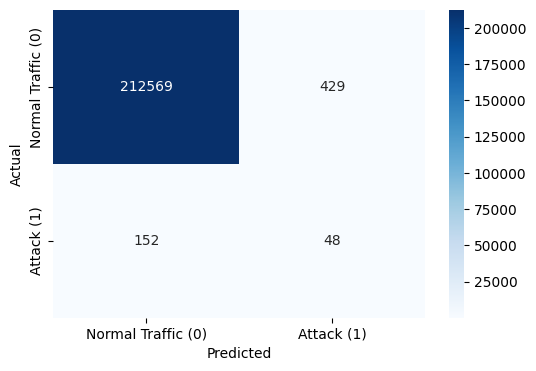

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    212998
        Attack       0.10      0.24      0.14       200

      accuracy                           1.00    213198
     macro avg       0.55      0.62      0.57    213198
  weighted avg       1.00      1.00      1.00    213198



In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
y_pred = final_model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [37]:
import numpy as np
import pandas as pd

X_orig_success = scaler_full.inverse_transform(X_attack)
X_adv_success  = scaler_full.inverse_transform(X_attacked_after)

# --- 3) Build DataFrames with your desired columns and formatting ---
cols = selected_features

def make_df(X, preds):
    df = pd.DataFrame(X, columns=cols)
    return df

# df_orig = make_df(X_orig_success, pred_orig)
# df_adv  = make_df(X_adv_success,  pred_adv)

# --- 4) Show up to 10 examples in your exact format ---
n_show = min(10, len(df_orig))

# display settings (same style as earlier)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 6)
pd.set_option('display.width', 100)

# print("\n🟦 Original Attack Samples (that later flipped 1→0):\n")
# print(df_original)

# print("\n🟥 Corresponding Adversarial Samples:\n")
# print(df_adversarial)

print("\n🟦 Original Attack Samples (that later flipped 1→0):\n")
print(df_orig.head(n_show).to_string(index=True))

print("\n🟥 Adversarial Counterparts:\n")
print(df_adv.head(n_show).to_string(index=True))



🟦 Original Attack Samples (that later flipped 1→0):

    sttl  ct_state_ttl  dmeansz         Sload    ackdat   dttl  sbytes    synack    tcprtt  smeansz         Dload  state  dbytes       Dintpkt       dur         Ltime         Stime  ct_srv_dst
0  254.0           1.0    149.0  4.496946e+03  0.085696  252.0  1888.0  0.085870  0.171566    157.0   5037.307617    5.0  2088.0  2.302192e+02  3.079423  1.421933e+09  1.421933e+09         1.0
1  254.0           2.0      0.0  1.520000e+08  0.000000    0.0   114.0  0.000000  0.000000     57.0      0.000000    6.0     0.0 -1.421085e-14  0.000003  1.421932e+09  1.421932e+09        11.0
2  254.0           1.0    122.0  1.157428e+04  0.046698  252.0  3456.0  0.070368  0.117066    133.0  10627.166020    5.0  3174.0  8.906380e+01  2.297508  1.421930e+09  1.421930e+09         1.0
3  254.0           2.0      0.0  8.000000e+07  0.000000    0.0   200.0  0.000000  0.000000    100.0      0.000000    6.0     0.0 -1.421085e-14  0.000010  1.421931e+09  1.4219

In [53]:
import numpy as np
import pandas as pd

# --- 1) Collect only the successfully flipped samples (1 → 0) ---
success_mask = zoo_attack_on_attacks["successes_bool"]
attacked_idx = zoo_attack_on_attacks["attacked_indices"]
successful_local_idx = np.array(attacked_idx)[success_mask]

# Standardized (model-space) originals + adversarials for those successes
X_orig_success_std = X_attack[successful_local_idx]
X_adv_success_std  = zoo_attack_on_attacks["X_adv"][successful_local_idx]

# Sanity: keep only those that truly flipped 1->0 according to the model
pred_orig = (final_model.predict(X_orig_success_std, verbose=0).ravel() > 0.5).astype(int)
pred_adv  = (final_model.predict(X_adv_success_std,  verbose=0).ravel() > 0.5).astype(int)

flip_mask = (pred_orig == 1) & (pred_adv == 0)
X_orig_success_std = X_orig_success_std[flip_mask]
X_adv_success_std  = X_adv_success_std[flip_mask]
pred_orig = pred_orig[flip_mask]
pred_adv  = pred_adv[flip_mask]

# --- 2) Inverse-transform back to original feature units ---
# scaler_full was fit on the selected columns used by the model (Xtr_sel)
X_orig_success = scaler_full.inverse_transform(X_orig_success_std)
X_adv_success  = scaler_full.inverse_transform(X_adv_success_std)

# --- 3) Build DataFrames with your desired columns and formatting ---
cols = selected_features

def make_df(X, preds):
    df = pd.DataFrame(X, columns=cols)
    return df

df_orig = make_df(X_orig_success, pred_orig)
df_adv  = make_df(X_adv_success,  pred_adv)

# --- 4) Show up to 10 examples in your exact format ---
n_show = min(10, len(df_orig))

# display settings (same style as earlier)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 6)
pd.set_option('display.width', 100)

# print("\n🟦 Original Attack Samples (that later flipped 1→0):\n")
# print(df_original)

# print("\n🟥 Corresponding Adversarial Samples:\n")
# print(df_adversarial)

print("\n🟦 Original Attack Samples (that later flipped 1→0):\n")
print(df_orig.head(n_show).to_string(index=True))

print("\n🟥 Adversarial Counterparts:\n")
print(df_adv.head(n_show).to_string(index=True))



🟦 Original Attack Samples (that later flipped 1→0):

    sttl  ct_state_ttl  dmeansz         Sload    ackdat   dttl  sbytes    synack    tcprtt  smeansz         Dload  state  dbytes       Dintpkt       dur         Ltime         Stime  ct_srv_dst
0  254.0           1.0    149.0  4.496946e+03  0.085696  252.0  1888.0  0.085870  0.171566    157.0   5037.307617    5.0  2088.0  2.302192e+02  3.079423  1.421933e+09  1.421933e+09         1.0
1  254.0           2.0      0.0  1.520000e+08  0.000000    0.0   114.0  0.000000  0.000000     57.0      0.000000    6.0     0.0 -1.421085e-14  0.000003  1.421932e+09  1.421932e+09        11.0
2  254.0           1.0    122.0  1.157428e+04  0.046698  252.0  3456.0  0.070368  0.117066    133.0  10627.166020    5.0  3174.0  8.906380e+01  2.297508  1.421930e+09  1.421930e+09         1.0
3  254.0           2.0      0.0  8.000000e+07  0.000000    0.0   200.0  0.000000  0.000000    100.0      0.000000    6.0     0.0 -1.421085e-14  0.000010  1.421931e+09  1.4219

In [52]:
print("==== ZOO on attack samples (targeted to NORMAL / 0) ====")
for k, v in zoo_attack_on_attacks.items():
    if k in {"X_adv", "attacked_indices", "successes_bool", "queries_each", "iters_each"}:
        continue
    print(f"{k}: {v}")

# --- 3) Evaluate evasion on attacked subset and overall attack set ---
X_attack_adv = zoo_attack_on_attacks["X_adv"]  # same shape as X_attack; attacked indices modified
attacked_local_idx = zoo_attack_on_attacks["attacked_indices"]
success_flags = zoo_attack_on_attacks["successes_bool"]
queries_each = zoo_attack_on_attacks["queries_each"]

# Predictions AFTER on attack-only array (includes both attacked & untouched elements)
pred_attack_after = (final_model.predict(X_attack_adv, verbose=0).ravel() > 0.5).astype(int)
tpr_after = (pred_attack_after == 1).mean()
evasion_rate_all_attacks = (pred_attack_after == 0).mean()

# Evasion rate restricted to actually ATTACKED samples
evasion_rate_attacked = success_flags.mean() if len(success_flags) else 0.0
avg_queries_attacked = queries_each.mean() if len(queries_each) else 0.0

print(f"\n--- Evasion results ---")
print(f"Detection rate on attack samples BEFORE: {tpr_before:.3f}")
print(f"Detection rate on attack samples AFTER:  {tpr_after:.3f}")
print(f"Evasion rate among ALL attack samples:   {evasion_rate_all_attacks:.3f}")
print(f"Evasion rate among ATTACKED subset:      {evasion_rate_attacked:.3f}")
print(f"Avg queries per attacked sample:         {avg_queries_attacked:.1f}")

# --- 4) (Optional) Put adversarial attacks back into the FULL test matrix ---
# This is handy if you want to re-run a full classification report after evasion.
Xte_adv_full = Xte_sel.copy()
global_attack_indices = np.where(attack_mask)[0]
Xte_adv_full[global_attack_indices] = X_attack_adv

# Example: full post-attack report
test_preds_after = (final_model.predict(Xte_adv_full, verbose=0).ravel() > 0.5).astype(int)

from sklearn.metrics import classification_report
print("\nFinal Test Set Report AFTER targeted ZOO on attack samples:")
print(classification_report(y_test, test_preds_after, zero_division=0))


==== ZOO on attack samples (targeted to NORMAL / 0) ====
num_attacked: 4198
only_on_correct: True
targeted: 0
eps: 0.3
norm: linf
steps: 300
lr: 0.1
h: 0.001
success_rate: 0.7582181991424488
avg_queries: 2833.319437827537
avg_iters: 76.54263935207241
acc_before_on_subset: 1.0
acc_after_on_subset: 0.24178180085755122

--- Evasion results ---
Detection rate on attack samples BEFORE: 0.945
Detection rate on attack samples AFTER:  0.228
Evasion rate among ALL attack samples:   0.772
Evasion rate among ATTACKED subset:      0.758
Avg queries per attacked sample:         2833.3

Final Test Set Report AFTER targeted ZOO on attack samples:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    212998
           1       0.70      0.23      0.34      4443

    accuracy                           0.98    217441
   macro avg       0.84      0.61      0.67    217441
weighted avg       0.98      0.98      0.98    217441

